# Import Libraries

In [1]:
import pandas as pd 
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import gensim 
from gensim.test.utils import common_texts, get_tmpfile
from gensim import corpora, models, similarities 
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import math

from nltk import sent_tokenize, word_tokenize, PorterStemmer
from nltk.corpus import stopwords 


# Preprocessing

In [2]:
def preprocessing(corpus):
        #Stemer and lemmatizer function
    def stemer_lemmatizer(stopwords_tokens):
      processed = []
      stemmer = PorterStemmer()
      lemmatizer = WordNetLemmatizer()
      for x,test_word in enumerate(stopwords_tokens):
        word_stem = stemmer.stem(test_word)
        word_lemmatise = lemmatizer.lemmatize(word_stem)
        processed.append(word_lemmatise)
      return processed

    #Text proceccing function
    def process_text(mytext):
      tokenizer = RegexpTokenizer(r'[^\d\W]+')
      regexp_tokens = tokenizer.tokenize(mytext.lower())
      stopwords_tokens = [token for token in regexp_tokens if token not in stopwords.words('english')]
      return stopwords_tokens

    processed_sent_list = []
    sent_tokens = sent_tokenize(corpus)
    for sentence in sent_tokens:
        processed_sent = process_text(sentence)
        processed_sent = stemer_lemmatizer(processed_sent)
        processed_sent_list.append(processed_sent)
    return processed_sent_list

# Word2Vec
First of all, you know you can’t feed a word just as a text string to a neural network

In [3]:
def vectorize_words(processed_sent_list):
    model = gensim.models.Word2Vec(processed_sent_list, min_count=1, size = 32 )
    model.save("word2vec_model")
    word_vectors = Word2Vec.load("word2vec_model").wv
    
    print('#Test output for words in word2vec')

    for i, word in enumerate(word_vectors.vocab):
        if i == 10:
            break
        print(word)
    
    return word_vectors

# KMeans Cluster

In [4]:
def kmeans_cluster(word_vectors):
    #Create a cluster of two cenroids for positive and negative clusters using word to vect labels
    model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors)
    positive_cluster_center = model.cluster_centers_[0]
    negative_cluster_center = model.cluster_centers_[1]
    print(model.cluster_centers_)
    #We use gensim’s most similar method to check for clusters that are positive and negative based on cosine distance.
    #print zero for positive clusters, and 1 for negative
    word_vectors.similar_by_vector(model.cluster_centers_[0], topn=20, restrict_vocab=None)
    #We use gensim’s most similar method to check for clusters that are positive and negative based on cosine distance.
    #print zero for positive clusters, and 1 for negative
    word_vectors.similar_by_vector(model.cluster_centers_[1], topn=20, restrict_vocab=None)

    #Kmeans cluster visualization
    y_km = model.fit_predict(word_vectors.vectors)

    # plot the 3 clusters
    plt.scatter(
        word_vectors.vectors[y_km == 0, 0], word_vectors.vectors[y_km == 0, 1],
        s=50, c='lightgreen',
        marker='s', edgecolor='black',
        label='cluster 0'
    )

    plt.scatter(
        word_vectors.vectors[y_km == 1, 1], word_vectors.vectors[y_km == 1, 0],
        s=50, c='orange',
        marker='o', edgecolor='black',
        label='cluster 1'
    )

    # plot the centroids
    plt.scatter(
        model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], 
        s=250, marker='*',
        c='red', edgecolor='black',
        label='centroids'
    )
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.show()
    
    return model

# Assigning clusters

In [5]:
def assign_clusters(model, word_vectors):
    
    df_assign_clusters = pd.DataFrame(word_vectors.vocab.keys())
    df_assign_clusters.columns = ['words']
    df_assign_clusters['vectors'] = df_assign_clusters.words.apply(lambda x: word_vectors.wv[f'{x}'])
    df_assign_clusters['cluster'] = df_assign_clusters.vectors.apply(lambda x: model.predict([np.array(x)]))
    df_assign_clusters.cluster = df_assign_clusters.cluster.apply(lambda x: x[0])
    df_assign_clusters['cluster_value'] = [1 if i==0 else -1 for i in df_assign_clusters.cluster]
    df_assign_clusters['closeness_score'] = df_assign_clusters.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
    df_assign_clusters['sentiment_coeff'] = df_assign_clusters.closeness_score * df_assign_clusters.cluster_value
    
    
    return df_assign_clusters

# Tfidf weighting and sentiment prediction

In [6]:
def tf_idf_weighting(df_assign_clusters):
    
    #1. Create the Frequency matrix of the words in each sentence.
    #We calculate the frequency of words in each sentence.

    def _create_frequency_matrix(sentences):
        frequency_matrix = {}
        stopWords = set(stopwords.words("english"))
        ps = PorterStemmer()

        for sent in sentences:
            freq_table = {}
            words = word_tokenize(sent)
            for word in words:
                word = word.lower()
                word = ps.stem(word)
                if word in stopWords:
                    continue

                if word in freq_table:
                    freq_table[word] += 1
                else:
                    freq_table[word] = 1

            #frequency_matrix[sent[:15]] = freq_table
            frequency_matrix[sent.split(',')[0]] = freq_table

        return frequency_matrix  
    
    # 2. Calculate TermFrequency and generate a matrix
    # We’ll find the TermFrequency for each word in a paragraph.
    # Now, remember the definition of TF,
    # TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
    # Here, the document is a paragraph, the term is a word in a paragraph. 
    def _create_tf_matrix(freq_matrix):
        tf_matrix = {}

        for sent, f_table in freq_matrix.items():
            tf_table = {}

            count_words_in_sentence = len(f_table)
            for word, count in f_table.items():
                tf_table[word] = count / count_words_in_sentence

            tf_matrix[sent] = tf_table

        return tf_matrix
    
    # 3. Creating a table for documents per words
    # This again a simple table which helps in calculating IDF matrix.
    # we calculate, “how many sentences contain a word”, Let’s call it Documents per words matrix.
    def _create_documents_per_words(freq_matrix):
        word_per_doc_table = {}

        for sent, f_table in freq_matrix.items():
            for word, count in f_table.items():
                if word in word_per_doc_table:
                    word_per_doc_table[word] += 1
                else:
                    word_per_doc_table[word] = 1

        return word_per_doc_table

    # 3. Calculate IDF and generate a matrix
    # We’ll find the IDF for each word in a paragraph.
    # Now, remember the definition of IDF,
    # IDF(t) = log_e(Total number of documents / Number of documents with term t in it)
    # Here, the document is a paragraph, the term is a word in a paragraph. 
    def _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents):
        idf_matrix = {}

        for sent, f_table in freq_matrix.items():
            idf_table = {}

            for word in f_table.keys():
                idf_table[word] = math.log10(total_documents / float(count_doc_per_words[word]))

            idf_matrix[sent] = idf_table

        return idf_matrix
 
    # 5. Calculate TF-IDF and generate a matrix
    # Now we have both the matrix and the next step is very easy.
    # TF-IDF algorithm is made of 2 algorithms multiplied together.
    # In simple terms, we are multiplying the values from both the matrix and generating new matrix.
    def _create_tf_idf_matrix(tf_matrix, idf_matrix):
        tf_idf_matrix = {}

        for (sent1, f_table1), (sent2, f_table2) in zip(tf_matrix.items(), idf_matrix.items()):

            tf_idf_table = {}

            for (word1, value1), (word2, value2) in zip(f_table1.items(),
                                                        f_table2.items()):  # here, keys are the same in both the table
                tf_idf_table[word1] = float(value1 * value2)

            tf_idf_matrix[sent1] = tf_idf_table

        return tf_idf_matrix  
    
    # 5. Score the sentences Scoring a sentence is differs with different algorithms. 
    # Here, we are using Tf-IDF score of words in a sentence to give weight to the paragraph.
    def _score_sentences(tf_idf_matrix) -> dict:
        """
        score a sentence by its word's TF
        Basic algorithm: adding the TF frequency of every non-stop word in a sentence divided by total no of words in a sentence.
        :rtype: dict
        """

        sentenceValue = {}

        for sent, f_table in tf_idf_matrix.items():
            total_score_per_sentence = 0

            count_words_in_sentence = len(f_table)
            for word, score in f_table.items():
                total_score_per_sentence += score

            sentenceValue[sent] = total_score_per_sentence / count_words_in_sentence

        return sentenceValue

    # 7. Find the threshold Similar to any summarization algorithms, 
    # there can be different ways to calculate a threshold value. 
    # We’re calculating the average sentence score.
    def _find_average_score(sentenceValue) -> int:
        """
        Find the average score from the sentence value dictionary
        :rtype: int
        """
        sumValues = 0
        for entry in sentenceValue:
            sumValues += sentenceValue[entry]

        # Average value of a sentence from original summary_text
        average = (sumValues / len(sentenceValue))

        return average

    

    
    
    # 8. Assign weights to dataframe 
    def assign_weightings(tf_idf_matrix, df_assign_clusters):
        df_assign_clusters["tfidf_weights"] = 0.0
        for i, clusterWord in df_assign_clusters.iterrows(): 
            #print(x.words)
            for key, value in tf_idf_matrix[str(song)].items():
                if clusterWord.words == key:
                    print(key, value)
                    df_assign_clusters["tfidf_weights"][i] = value
        df_tf_idf_weighting = df_assign_clusters 
        
        
        return df_tf_idf_weighting

    

    # '''
    # We already have a sentence tokenizer, so we just need 
    # to run the sent_tokenize() method to create the array of sentences.
    # '''
    # # 1 Sentence Tokenize
    sentences = sent_tokenize(corpus)
    total_documents = len(sentences)
    print(sentences)
    print('')
    print('')
    # 2 Create the Frequency matrix of the words in each sentence.
    freq_matrix = _create_frequency_matrix(sentences)
    print('')
    print('')
    print(freq_matrix)

    '''
    Term frequency (TF) is how often a word appears in a document, divided by how many words are there in a document.
    '''
    # 3 Calculate TermFrequency and generate a matrix
    tf_matrix = _create_tf_matrix(freq_matrix)
    print('')
    print('')
    print(tf_matrix)

    # 4 creating table for documents per words
    count_doc_per_words = _create_documents_per_words(freq_matrix) 
    print('')
    print('')
    print('4 creating table for documents per words - _create_documents_per_words')
    print('')
    print(count_doc_per_words)

    '''
    Inverse document frequency (IDF) is how unique or rare a word is.
    '''
    # 5 Calculate IDF and generate a matrix
    idf_matrix = _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents)
    print('')
    print('')
    print('5 Calculate IDF and generate a matrix - _create_idf_matrix')
    print('')
    print(idf_matrix)

    # 6 Calculate TF-IDF and generate a matrix
    tf_idf_matrix = _create_tf_idf_matrix(tf_matrix, idf_matrix)
    print('')
    print('')
    print('6 Calculate TF-IDF and generate a matrix - _create_tf_idf_matrix')
    print('')
    print(tf_idf_matrix)

    # 7 Important Algorithm: score the sentences
    sentence_scores = _score_sentences(tf_idf_matrix)
    print('')
    print('')
    print('7 Important Algorithm: score the sentences - _score_sentences')
    print('')
    print(sentence_scores)

    # 8 Find the threshold
    threshold = _find_average_score(sentence_scores)
    print('')
    print('')
    print('8 Find the threshold - _find_average_score')
    print('')
    print(threshold)

    # 9. Assign weights to dataframe 
    df_tf_idf_weighting = assign_weightings(tf_idf_matrix, df_assign_clusters)
    print(df_tf_idf_weighting)
    
    return df_tf_idf_weighting, threshold





# Sentiment Prediction

In [7]:
def sentiment_prediction(tf_idf_weighting, threshold):
    
    
    #get dataframe with tf-idf weights >= threshold
    df_tf_idf_weighting_above_treshold = tf_idf_weighting[tf_idf_weighting["tfidf_weights"] >= threshold]
    #get dataframe with cluster == 1. Basically negative clusters
    df_negative_sentiment = df_tf_idf_weighting_above_treshold[df_tf_idf_weighting_above_treshold["cluster"] == 1]
    #Sum the weights of all relevent negative sentiments in the song
    sum_of_relevant_negative_weights = df_negative_sentiment["tfidf_weights"].sum()
    sum_of_relevant_negative_weights


    #get dataframe with cluster == 0. Basically positive clusters
    df_positive_sentiment = df_tf_idf_weighting_above_treshold[df_tf_idf_weighting_above_treshold["cluster"] == 0]
    #Sum the weights of all relevent positve sentiments in the song
    sum_of_relevant_positive_weights = df_positive_sentiment["tfidf_weights"].sum()
    sum_of_relevant_positive_weights
    
    

    if sum_of_relevant_negative_weights > sum_of_relevant_positive_weights:
        sentiment = "Negative"
        tf_idf_weighting
    elif sum_of_relevant_negative_weights < sum_of_relevant_positive_weights:
        sentiment = "Positive"
    else:
        sentiment = "Neutral"

    print("The sentiment prediction of the song is ", sentiment)
    
    return sentiment

# Command Center


Import Data

*************************** Start preprocessing  Bruno Mars  -  All About You *******************************************
*************************** Start vectorization  Bruno Mars  -  All About You *******************************************
#Test output for words in word2vec
know
girl
look
feel
caus
usual
nonchal
conceal
want
oh
*************************** Start kmeans cluster  Bruno Mars  -  All About You *******************************************
[[ 2.6734307e-04  9.7689126e-04 -1.5044619e-03  1.5469455e-03
  -1.6420236e-05  3.6699178e-03 -1.5485043e-03 -5.6268531e-05
   5.9390871e-04 -2.3646245e-03  1.2190453e-03  4.6204077e-03
   3.2327273e-03 -7.6022523e-04 -1.6814938e-03  9.2382263e-04
  -7.5287319e-04  3.9972509e-03  4.0077080e-05  1.4647195e-04
   3.4554824e-03 -6.6313054e-04 -1.1770354e-03  3.8252678e-05
   1.0541873e-04  1.6917156e-03  1.2521050e-05 -4.5084395e-05
   5.1055034e-04 -6.7174062e-04  1.7316246e-03  1.5756115e-03]
 [ 8.7930216e-04 -1.9311034e-03  8.1552025e-03

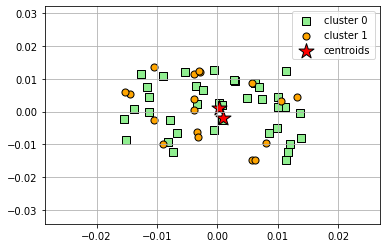

*************************** Start assigning cluster  Bruno Mars  -  All About You *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  All About You *******************************************
["All About You, I know girl, when you look at me  \nYou don't know how I feel  \nCause I'm usually so nonchalant  \nMy feelings I conceal  \nBut I want you to know  \nOh, I want you to know  \n  \nI must admit I've felt this way for more than quite a while  \nBut I can't hold it no longer when I see that pretty smile  \nCan't wait no more  \nOh, I can't wait no more  \n  \nOooh  \n  \n[Chorus:]  \nGirl, to tell you the truth  \nIt's alway's been you  \nI'm all about you  \nOh, girl  \nNo one can do me the way you do  \nIt's always been you  \nI'm all about you  \n  \nMaybe I'm a fool for speaking up but I don't mind  \nCause a girl like you will come around like  \nOnce in a million times  \nSo what do I do?", "Tell me what do I do  \n  \

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Circles *******************************************
#Test output for words in word2vec
circl
got
go
c
heart
dizzi
tell
suppos
night
feel
*************************** Start kmeans cluster  Bruno Mars  -  Circles *******************************************
[[-4.0188599e-03  1.4956678e-03 -1.3165311e-03 -3.2887221e-03
  -4.9419124e-03  3.4370245e-03 -4.0516444e-03 -6.9468864e-04
   2.4306466e-04 -5.1055551e-03 -3.8662401e-04 -2.1215236e-04
   4.9336860e-03 -1.1514465e-04 -9.4127171e-03  3.0935660e-03
   1.4549162e-03 -6.4751017e-04  3.8573982e-03  3.0086748e-03
  -6.0247774e-03  3.2736356e-03  3.1777306e-03  1.3509453e-03
  -1.4038271e-03  2.0141155e-03  5.8633797e-03 -3.0825303e-03
  -6.3837040e-03 -2.0409492e-03  2.1478410e-03 -6.1537479e-03]
 [ 3.6905394e-03 -2.3708963e-03  4.9301592e-04  3.8167802e-03
   1.1624383e-03 -1.1807389e-03  1.5810871e-03  2.5666035e-03
  -6.6548667e-04  1.3936658e-03 -5.6482415e-04  4.5417211e-04

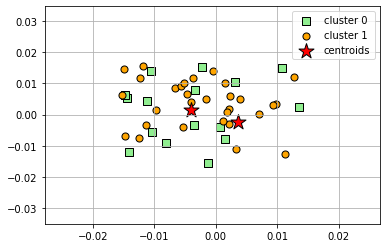

*************************** Start assigning cluster  Bruno Mars  -  Circles *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Circles *******************************************
["Circles, Got me going in circles c-circles  \nMy heart is dizzy from you  \nGot me going in circles c-circles  \nTell me what I'm supposed to do  \nYou got me up at night  \nFeeling like  \nYou won't come thru  \nGot me going in circles c-circles  \nMy heart is dizzy from you  \nRound and are-are-are-round we go (x2)  \nRound and are-are-are-round  \nI'm goin' in circles c-circles  \nPlease girl!", "I give you everything, but, it's not enough  \nYou started being easy but lately you've made it rough (for us)  \nYou say you need me but then turn me away  \nGot me oh so confused, should I leave or should I stay?", '(Baby tell me what you want) Alittle more time  \n(Baby tell me what you need) Baby all your love  \n(How far you tryna go?)', "All the wa

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Click Clack Away *******************************************
#Test output for words in word2vec
click
clack
away
shot
heart
stare
eye
might
die
happi
*************************** Start kmeans cluster  Bruno Mars  -  Click Clack Away *******************************************
[[-2.0008977e-03  3.3984717e-03  3.4748758e-03  1.2559757e-03
   2.2131049e-03  7.5215742e-04  3.4996396e-04 -1.0339386e-04
   7.8641612e-04  4.2477730e-03  2.6912668e-03 -2.6694470e-04
   1.5344738e-04  1.6427729e-03 -1.9118788e-03 -3.3047525e-03
   2.0506789e-03 -5.5036042e-05 -1.1423244e-03  2.1212883e-03
  -2.4495551e-03  7.5338525e-05  1.1830875e-03  1.2714290e-03
  -2.8175151e-03  2.8311608e-03  9.7226707e-04  6.0341653e-04
  -2.0700274e-05 -2.0653040e-03 -2.5577261e-03 -1.4998476e-03]
 [ 2.8630889e-03 -1.2301076e-03 -5.9137782e-03  9.6282497e-04
   4.4435629e-04 -1.4412802e-03 -9.0469333e-04  6.5870886e-04
  -2.0595070e-03 -4.6277782e-03 -3.2280

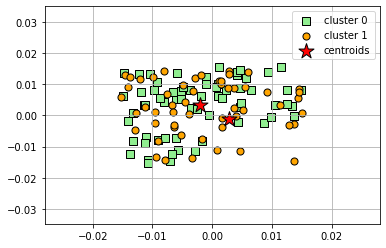

*************************** Start assigning cluster  Bruno Mars  -  Click Clack Away *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Click Clack Away *******************************************
["Click Clack Away, You shot me through the heart staring in your eyes  \nSo I might die a happy man today  \nJust empty out your barrel girl  \nIt's alright  \nClick clack away  \n(Click clack away)  \nClick clack away  \n(Click clack away)  \n  \nGo 'head  \nPull it pull it pull it  \nYeah yeah  \nPull it pull it pull it  \nYeah yeah  \nPull it pull it  \nGo ahead make my day (make my day)  \nClick clack away  \n  \nYou got weapons of mass seduction  \nIf I was broke I'd give you half of nothing  \nOr give it all then I give you more  \nI'm no decorator but the writing's on the wall  \nWinter summer fall, April, May and June  \nYou shot me through the heart but I don't have a wound  \nYou got a good aim cause I could've sworn I mov

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



may 0.0
june 0.0
wound 0.0
good 0.0
aim 0.0
caus 0.0
could 0.0
sworn 0.0
move 0.0
come 0.0
relationship 0.0
clue 0.0
love 0.0
first 0.0
sight 0.0
know 0.0
zoom 0.0
put 0.0
hit 0.0
ba 0.0
da 0.0
bing 0.0
boom 0.0
pain 0.0
let 0.0
hurri 0.0
suffer 0.0
kill 0.0
tougher 0.0
tough 0.0
whassup 0.0
fire 0.0
swear 0.0
duck 0.0
wow 0.0
awe 0.0
shoot 0.0
draw 0.0
take 0.0
breath 0.0
call 0.0
mari 0.0
cleft 0.0
need 0.0
ask 0.0
readi 0.0
ye 0.0
get 0.0
tux 0.0
dress 0.0
gon 0.0
big 0.0
although 0.0
met 0.0
fresh 0.0
mess 0.0
like 0.0
spontanu 0.0
continu 0.0
flow 0.0
sit 0.0
press 0.0
charg 0.0
want 0.0
ricochet 0.0
anoth 0.0
target 0.0
edg 0.0
right 0.0
margin 0.0
see 0.0
firework 0.0
feel 0.0
spark 0.0
hope 0.0
keep 0.0
centr 0.0
bullsey 0.0
benefit 0.0
full 0.0
time 0.0
everyth 0.0
       words                                            vectors  cluster  \
0      click  [-0.010732453, -0.014225145, 0.003965754, 0.00...        0   
1      clack  [-0.0052632573, 0.007930718, 0.0017533004, -0...

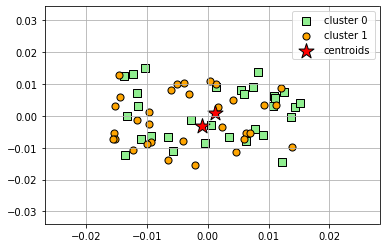

*************************** Start assigning cluster  Bruno Mars  -  Don't Give Up *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Don't Give Up *******************************************
["Don't Give Up, [Bruno Mars]  \nWhen you want to do something that's new  \nAnd it seems really, really hard to do  \nYou feel like quitting, you feel you're through  \nWell I have some advice for you  \n  \nDon't give up  \nKeep on trying  \nYou're gonna make it  \nI ain't lying  \nDon't give up, don't ever quit  \nTry and try and you can do it  \nDon't give up, yeah  \n  \nIf you want to catch a ball  \nBut you're having no luck at all  \nThe ball hits your head, it hits your nose  \nIt hits your belly, your chin and toes  \nWell, try and try and try again  \nKeep on trying until the end  \nYou put your hands out in the air  \nYou'll catch the ball  \nYes this I swear  \n  \nDon't give up,  \nKeep on going  \nYou're on a boat,  \nSo kee

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Dreamtaker *******************************************
#Test output for words in word2vec
dreamtak
oooohhhh
ooohhhh
use
go
mind
tryna
defin
real
mean
*************************** Start kmeans cluster  Bruno Mars  -  Dreamtaker *******************************************
[[ 2.7416798e-03 -2.7844083e-04  4.2446633e-03  5.5223631e-05
   2.7124677e-03 -2.0774186e-03 -3.3470788e-03 -4.1283085e-03
  -2.3187869e-03 -8.6467084e-04  9.1722334e-04  3.3030240e-04
   2.7763431e-03 -2.1688081e-03  1.3837076e-03 -3.9622998e-03
  -1.8340452e-03  6.5836834e-04  8.0550462e-04  6.4854586e-04
  -6.0893390e-03 -1.1729166e-03  3.7600752e-04 -4.8949285e-03
  -4.5837313e-03 -2.9633087e-03  3.4816889e-04 -2.5676903e-03
  -1.8310060e-03 -8.9080643e-04  1.5717780e-03 -2.0609680e-03]
 [-1.3165805e-03 -1.7738219e-03 -3.2660831e-03 -4.8413861e-04
   9.5484051e-04  3.8706989e-04  1.1876276e-03  3.4643714e-03
   3.2760380e-03 -3.7190784e-03 -1.1450093e-0

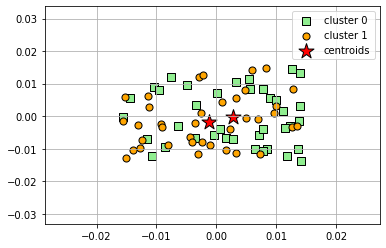

*************************** Start assigning cluster  Bruno Mars  -  Dreamtaker *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Dreamtaker *******************************************
["Dreamtaker, Oooohhhh ooohhhh  \n  \nI used to go out of my mind tryna re define the real meaning of love  \nI lost my dignity forgot about me I was so lost in us  \nI had to take on, cause you had me stuck in the middle of nowhere  \nAnd my faith it would shake, I know you're trying your best to take me  \n  \nChorus: dream taker won't you leave me alone  \nBeen standing in the way for far too long  \nDream maker now it's taking your place  \nI'm no longer asleep my heart is finally awake  \nSo goodbye, good day, farewell, it's okay  \nDream taker won't you leave me alone  \nCan't wait til you're gone haven't dreamt in so long  \n  \nYou used to be the man of my dreams only now it seems you were just a\nnightmare  \nBut this little light of mi

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 0.0
alon 0.0
stand 0.0
way 0.0
far 0.0
long 0.0
maker 0.0
place 0.0
longer 0.0
asleep 0.0
heart 0.0
final 0.0
awak 0.0
goodby 0.0
good 0.0
day 0.0
farewel 0.0
okay 0.0
wait 0.0
til 0.0
gone 0.0
dreamt 0.0
man 0.005613191231996028
seem 0.005613191231996028
nightmar 0.005613191231996028
littl 0.005613191231996028
light 0.005613191231996028
mine 0.005613191231996028
told 0.005613191231996028
open 0.005613191231996028
eye 0.005613191231996028
dark 0.005613191231996028
run 0.0020716618712433086
ya 0.008286647484973235
imma 0.0020716618712433086
walk 0.0020716618712433086
afraid 0.0020716618712433086
escap 0.0020716618712433086
night 0.005613191231996028
see 0.005613191231996028
face 0.005613191231996028
            words                                            vectors  cluster  \
0        dreamtak  [0.006050511, -0.011462179, -0.0037590095, 0.0...        1   
1        oooohhhh  [-0.011694935, -0.003010082, -0.0008945098, -0...        1   
2         ooohhhh  [0.0125681935, 0.014439073, -

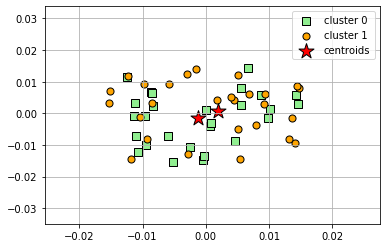

*************************** Start assigning cluster  Bruno Mars  -  Faded *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Faded *******************************************
["Faded, Am I In Love Or Am I Faded  \nYeah Yeah  \nI Wont Know Utill Tomorrow  \nAm I In Love Or Am I Faded  \nYeah Yeah  \nI don't Know  \nOoh Oh  \nOoh Oh  \nOoh Oh  \nOoh Oh Oh Ooh  \nOoh Oh  \nOoh Oh  \nOoh Oh Oh Ooh  \n  \nI don't Know What It Is What It Is About Ya  \nBut I can't Seem To Take My Eyes Off Ya  \nGotta Let You Know That I'm Meant to Ya  \nThe Later It Gets I Gotta Have ya  \nNow That I'm At The End Of The Bottle  \nShe Looks Like A Supermodel  \nI Think I'm Reasy To Go Oh  \nGive Her The Keys To My Car  \nI Think I Fell In Love With The Bar  \nTonight I'm Not Going Ho-O-Ome  \nOoh  \n  \nAm I In Love Or Am I Faded  \nYeah Yeah  \nI Wont Know Untill Tomorrow  \nAm I In Love Or Am I Faded  \nYeah Yeah  \nI don't Know  \nOoh Oh  \nOoh Oh

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 0.00493491796170461
eye 0.00493491796170461
let 0.00493491796170461
meant 0.00493491796170461
later 0.00493491796170461
get 0.00986983592340922
end 0.00986983592340922
bottl 0.00986983592340922
look 0.00986983592340922
like 0.0
supermodel 0.00986983592340922
think 0.02960950777022766
reasi 0.00986983592340922
go 0.01973967184681844
give 0.00986983592340922
key 0.00986983592340922
car 0.00986983592340922
fell 0.00986983592340922
bar 0.00986983592340922
tonight 0.01480475388511383
back 0.00986983592340922
club 0.00986983592340922
happen 0.01973967184681844
last 0.00986983592340922
night 0.00986983592340922
tipsi 0.00493491796170461
girl 0.00493491796170461
type 0.00493491796170461
late 0.00493491796170461
might 0.00493491796170461
much 0.0
drink 0.0
realli 0.0
feel 0.0
ever 0.0
situat 0.0
one 0.0
         words                                            vectors  cluster  \
0         fade  [0.012237201, 0.0051554656, 0.003925591, 0.009...        1   
1         love  [0.00067569903, -0.00

*************************** Start vectorization  Bruno Mars  -  First Time *******************************************
#Test output for words in word2vec
first
time
feel
like
danc
night
away
yesterday
rememb
ta
*************************** Start kmeans cluster  Bruno Mars  -  First Time *******************************************
[[ 2.8487369e-03 -4.7312211e-03  1.7990548e-03 -5.1773502e-03
  -2.1041764e-03  5.6855618e-03  3.1660352e-04 -9.7280112e-04
  -7.4254908e-04 -8.0307350e-03  1.1293862e-03 -6.2503861e-03
   1.4234119e-04  1.1877525e-03  3.2353781e-03  1.8038054e-04
   1.2964250e-03  7.0291581e-03  1.2844601e-03 -8.2439947e-05
  -3.9112666e-03 -9.0324422e-03 -8.2824833e-04  5.6072965e-04
  -3.2616232e-03  5.7820533e-04  2.9366498e-03 -2.4229541e-04
  -5.3747864e-03 -3.1764072e-03  4.0378184e-03 -1.8100481e-03]
 [-4.9664578e-03  5.2168558e-04 -1.5978072e-03  1.9815611e-04
   1.3002881e-03 -2.4582085e-03 -4.4805463e-04 -1.1130180e-03
  -3.0211647e-04 -5.2722590e-04 -1.8462532e-03  

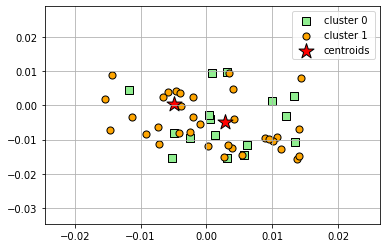

*************************** Start assigning cluster  Bruno Mars  -  First Time *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  First Time *******************************************
['First Time, I Feel Like Dancing The Night Away.', 'Feels Like Just Yesterday We Danced For The First Time, For The First Time,  \nRemember Our First Time, Time, Time, Time, Time, Ta Ta Ta Ta Ta Ta Oooh.', "Let's Let The Music Keep Our Bodies Awake.", "Feels Like I'm Touching You Right Now For The First Time, For The First  \nTime, Remember Our First Time, Time, Time, Time, Time, Ta Ta Ta Ta Ta Ta  \nOooh.", 'I Think I Might Explode, This Tension Is So Cold.', 'And All This Fighting Between Us Is Really Getting Old.', 'We Need A Magic Touch, Before It All Blows Up.', "We've Both Had Enough, We've Both Had Enough.", "So Let's Just Get Away, Go To That Special Place.", 'Where We First Met And On The Floor My Feet Were Swept Away.', "Baby It's Wor

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Girl In The Window *******************************************
#Test output for words in word2vec
girl
window
stare
room
see
hold
hand
wish
could
lover
*************************** Start kmeans cluster  Bruno Mars  -  Girl In The Window *******************************************
[[ 1.4828432e-03 -9.2253822e-04  4.4185827e-03 -2.5057674e-03
   2.2737158e-03  2.6164758e-03  1.0581379e-03 -8.9040271e-04
  -8.3435443e-04 -2.9718953e-03  2.3574901e-03  2.4368288e-03
  -3.1921747e-03 -1.8523657e-04 -3.3835117e-03  4.5341672e-05
  -8.9124759e-04  4.4364934e-03 -8.7760552e-04 -5.7071738e-05
  -2.0626346e-03  1.7517917e-03  5.1028479e-04  1.3099649e-03
  -2.1915752e-03 -1.2071530e-03  4.5059756e-03 -4.1732204e-04
  -1.0734262e-03  1.3849785e-03  8.7016297e-04 -5.6662234e-03]
 [ 1.8001591e-03 -3.3997807e-03 -6.9230292e-03  1.2078141e-03
  -3.3707949e-03  5.8947597e-05 -7.5985881e-04  1.7577603e-03
  -2.1348540e-03 -1.0100529e-03 -1.

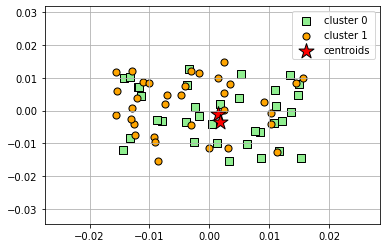

*************************** Start assigning cluster  Bruno Mars  -  Girl In The Window *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Girl In The Window *******************************************
["Girl In The Window, Staring from my room I see them  \nHolding hands wish I could be them  \nLovers doing what we use to do  \n(But I'm stuck here alone)  \nThat's the way it's been here lately  \nYou're too busy now to save me  \nFeels like you forget I'm waiting for you  \n  \nSometimes I wish I could just let go  \nBut I love you (I love you)  \nAnd I believe that one day you will come around  \nBut can you tell me  \n  \nHow do I always end up being the girl at the window  \n(Window, window)  \nI tell myself I'm not gonna wait for you whenever you go  \n(You go, you go)  \nYou give me your word and I always take it  \nYou say you'll be home but you never make it  \nSo why do I...", "Always end up that girl at the window (th

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 0.002402668011698076
never 0.002402668011698076
make 0.002402668011698076
       words                                            vectors  cluster  \
0       girl  [-0.0037475964, 0.007750577, 0.0053673135, -0....        0   
1     window  [-0.004513335, -0.0030967998, -0.014923946, 0....        1   
2      stare  [-0.013222703, -0.008387242, 0.009321858, 0.00...        0   
3       room  [-0.0039288285, -0.012651774, -0.0017972863, 0...        1   
4        see  [0.01108686, 0.001410671, 0.0056837015, -0.007...        0   
..       ...                                                ...      ...   
64  advantag  [0.013432713, 0.010982886, 0.01038721, -0.0119...        0   
65      caus  [-0.01182156, 0.007223, -0.00045730968, 0.0044...        0   
66      sure  [0.004832164, -0.0071136723, -0.0050080307, -0...        1   
67     wanna  [0.007642957, -0.00618391, 0.014778121, -0.001...        0   
68      whoa  [0.014741772, 0.0023550736, -0.008648475, -0.0...        1   

    cluster_

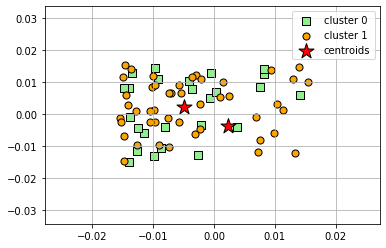

*************************** Start assigning cluster  Bruno Mars  -  It Will Rain *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  It Will Rain *******************************************
["It Will Rain, If you ever leave me baby,  \nLeave some morphine at my door  \n'Cause it would take a whole lot of medication  \nTo realize what we used to have,  \nWe don't have it anymore.", "There's no religion that could save me  \nNo matter how long my knees are on the floor  \nOoh so keep in mind all the sacrifices I'm makin'  \nWill keep you by my side  \nWill keep you from walkin' out the door.", "'Cause there'll be no sunlight  \nIf I lose you, baby  \nThere'll be no clear skies  \nIf I lose you, baby  \nJust like the clouds  \nMy eyes will do the same, if you walk away  \nEveryday it will rain  \n  \nI'll never be your mother's favorite  \nYour daddy can't even look me in the eye  \nOoh if I was in their shoes, I'd be doing the sa

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Ladies Is Pimps To *******************************************
#Test output for words in word2vec
ladi
pimp
choru
fresh
mall
brand
new
fit
go
nineti
*************************** Start kmeans cluster  Bruno Mars  -  Ladies Is Pimps To *******************************************
[[ 3.03456280e-03  1.55281730e-03  6.98228891e-04 -4.08452097e-03
  -8.51807534e-04  2.45214207e-04 -3.53290699e-03 -5.85685484e-07
  -1.18139724e-04  5.03755931e-04 -2.57715990e-04 -2.99667125e-03
   8.88163282e-04  8.83879606e-04 -1.52537879e-03 -2.90729897e-03
   1.52068015e-03  2.73060333e-03 -5.71903912e-03 -5.57145523e-03
  -1.72758568e-03  1.66943274e-03 -3.60703701e-03 -2.32200930e-03
   4.84423450e-04 -1.98493013e-03 -7.52581982e-04  3.89877404e-03
   2.01987661e-03 -2.26297439e-03 -1.28280395e-03  1.34986092e-03]
 [-4.87890211e-04 -1.45649689e-03  4.17787407e-04  1.05092768e-04
   8.16954125e-05 -2.95716943e-03  5.55110583e-03 -1.12804293e-0

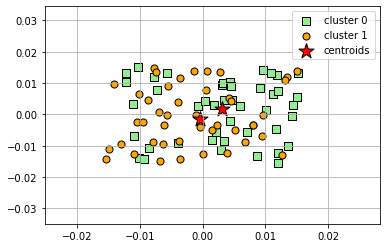

*************************** Start assigning cluster  Bruno Mars  -  Ladies Is Pimps To *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Ladies Is Pimps To *******************************************
["Ladies Is Pimps To, Chorus:  \nFresh out the mall in our brand new fits  \nGoing ninety five in our brand new whips  \nSayin (Ladies is pimps too) (3x)  \nOh  \n  \nStrut through the club yeah they know we so pay  \nStandin' on the table sippin' ace of spades  \nSayin (Ladies is pimps too) (3x)  \nOh  \n  \nVerse:  \nStandin at the bar, you know where we are  \nYou lookin for the best you don't have to look far  \nYea we some super models  \nBuyin our own bottles  \nLiving the good life, hard for them haters to swallow  \nAnd now were livin the dream  \nWe keep our purse full of cream  \nUs girls we get it in, money just like them  \nLadies holla if you feel me  \n  \nChorus:  \nFresh out the mall in our brand new fits  \nGoing

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 0.0
good 0.0
life 0.0
hard 0.0
hater 0.0
swallow 0.0
livin 0.0
dream 0.0
keep 0.0
purs 0.0
full 0.0
cream 0.0
girl 0.0
get 0.0
money 0.0
like 0.0
holla 0.0
feel 0.0
lou 0.0
vuitton 0.0
pump 0.0
match 0.0
hand 0.0
bag 0.0
diamond 0.0
neck 0.0
mean 0.0
brag 0.0
work 0.0
case 0.0
hear 0.0
check 0.0
mail 0.0
everyday 0.0
boy 0.0
aye 0.0
babi 0.0
getcha 0.0
paper 0.0
got 0.0
dime 0.0
buy 0.0
drink 0.0
grind 0.0
put 0.0
gotcha 0.0
hous 0.0
car 0.0
need 0.0
man 0.0
haa 0.0
    words                                            vectors  cluster  \
0    ladi  [0.013707871, 0.015020223, -0.0058946023, 0.01...        1   
1    pimp  [0.0006023824, -0.0069938875, -0.002985523, -0...        1   
2   choru  [-0.00020538601, -0.005687629, 0.01375903, 0.0...        1   
3   fresh  [0.0043914714, -0.0020559342, 0.012204709, -0....        0   
4    mall  [0.00041791672, 0.0042856187, 0.012406155, 0.0...        0   
..    ...                                                ...      ...   
83   hous  [-0.00

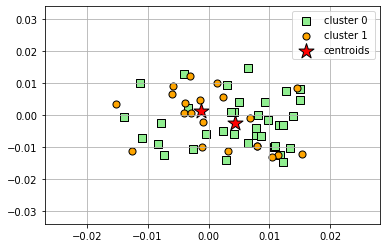

*************************** Start assigning cluster  Bruno Mars  -  Like Tonight *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Like Tonight *******************************************
['Like Tonight, Chorus:  \nSometimes I wonder what Heaven feels like?', 'I hope it feels like tonight,  \nHope it feels like tonight!', 'No one ever knows what tomorrow would be like,  \nI hope it feels like tonight,  \nHope it feels like tonight!', "With that look upon your face,  \nBaby I know what you're thinking about, oh!", "You've got your lips along my body,  \nAnd I'm not gonna stop you know, oh!", "You wanna take me to a place,  \nWhere I can't control my face somehow, oh!", "You know I'm down...", 'So boy, you gonna let me down, oh!', 'Oh, you got your love dripping all over me,  \nThe only thing I can say is: uhuu!', "I don't wanna wait,  \nJust... My days,  \nIt's yours, come get it, get it!", 'Chorus:  \nSometimes I wonder what 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Liquor Store Blues *******************************************
#Test output for words in word2vec
liquor
store
blue
greet
world
stand
whiskey
come
pore
feel
*************************** Start kmeans cluster  Bruno Mars  -  Liquor Store Blues *******************************************
[[-0.00052074 -0.00101828 -0.00291851  0.00146706  0.00233835 -0.00248152
   0.00359268  0.00095087  0.00036553  0.00069784  0.00270875  0.00220366
   0.00193024  0.00117001 -0.00010525 -0.0013452   0.00113408 -0.00069681
   0.00259619  0.00100737  0.000882    0.00021122 -0.00162451 -0.00334231
  -0.00095179  0.00077981  0.00182014  0.00047464  0.00307452 -0.00180383
   0.00235125 -0.00318411]
 [-0.00053893 -0.0048828   0.00251527 -0.00433664 -0.0010024   0.00219621
  -0.00594711 -0.00398411 -0.00268571 -0.00168998 -0.00168398 -0.00188145
   0.00277146 -0.00057255  0.00265331 -0.00169972 -0.00165911  0.00332256
  -0.00495216 -0.00109579  0.000

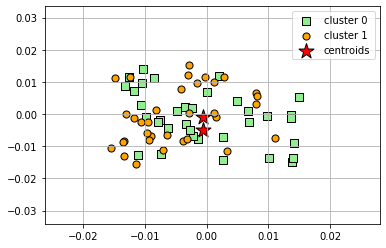

*************************** Start assigning cluster  Bruno Mars  -  Liquor Store Blues *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Liquor Store Blues *******************************************
['Liquor Store Blues, Now greetings to the world!', 'Standing at this liquor store,  \nWhiskey coming through my pores,  \nFeeling like I run this whole block.', "Lotto tickets cheap beer  \nThat's why you can catch me here,  \nTryna scratch my way up to the top.", "'Cause my job got me going nowhere,  \nSo I ain't got a thing to lose.", "Take me to a place where I don't care,  \nThis is me and my liquor store blues.", "I'll take one shot for my pain,  \nOne drag for my sorrow.", "Get messed up today,  \nI'll be ok tomorrow.", 'One shot for my pain,  \nOne drag for my sorrow.', "Get messed up today,  \nI'll be ok tomorrow.", 'Me and my guitar tonight,  \nSinging to the city lights,  \nTryna live on more than what I got.', "'Cause

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Locked Out Of Heaven *******************************************
#Test output for words in word2vec
lock
heaven
one
two
three
oh
yeah
uh
never
much
*************************** Start kmeans cluster  Bruno Mars  -  Locked Out Of Heaven *******************************************
[[-3.7041991e-03  3.8037091e-03 -2.7233048e-03 -3.1925079e-03
  -3.0937172e-03 -6.7474297e-04  3.6521950e-03  8.4830297e-04
   3.3581536e-04  3.2873813e-04  8.2769233e-04  7.7988207e-04
   5.5540698e-03  2.4869805e-03 -1.8126903e-04 -1.9073251e-03
   3.2037199e-03 -7.8877324e-04  5.3489367e-03  4.3862327e-03
  -1.9992588e-03 -1.9051845e-03  1.4983073e-03 -3.1006041e-03
  -3.6038398e-03 -8.2517514e-04  5.1228050e-03  2.1463260e-03
  -1.9377607e-03 -6.1085750e-04 -2.0116845e-03 -4.9555837e-03]
 [ 1.9215752e-03  9.6080371e-04  2.1449546e-03  3.6205908e-03
   2.2093281e-03  3.1484989e-03 -2.0725708e-03  2.9833612e-04
   6.7707570e-04 -2.7845907e-03  4.35

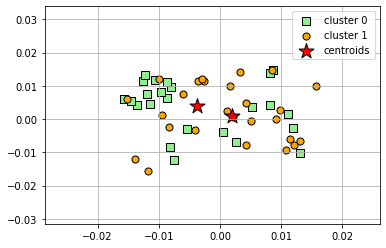

*************************** Start assigning cluster  Bruno Mars  -  Locked Out Of Heaven *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Locked Out Of Heaven *******************************************
['Locked Out Of Heaven, One, two, one, two, three  \n  \nOh yeah yeah  \nOh yeah yeah yeah, uh!', 'Oh yeah yeah  \nOh yeah yeah yeah, uh!', 'Never had much faith in love or miracles (miracles) uh!', 'Never wanna put my heart on the line, uh!', 'But swimming in your world is something spiritual (spiritual) uh!', "I'm born again every time you spend the night, uh!", "Cause your sex takes me to paradise  \nYeah your sex takes me to paradise  \nAnd it shows, yeah, yeah, yeah  \n'Cause you make me feel like, I've been locked out of heaven  \nFor too long, for too long  \nYeah you make me feel like, I've been locked out of heaven  \nFor too long, for too long  \n  \nOh yeah yeah yeah, uh!", 'Oh yeah yeah  \nOh yeah yeah yeah, uh!',

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Long Distance *******************************************
#Test output for words in word2vec
long
distanc
mani
song
sing
pas
time
run
thing
get
*************************** Start kmeans cluster  Bruno Mars  -  Long Distance *******************************************
[[ 3.4092963e-03  1.4322272e-03  2.2092406e-03  2.8175635e-03
   6.5998752e-03  2.4107371e-03  7.1608077e-04 -3.7826165e-03
  -8.5402094e-04  7.8323018e-04  1.0155197e-03 -1.1698320e-03
  -3.6457024e-04 -8.8244135e-04  1.1347946e-03  7.9090742e-04
   2.8496119e-03  3.9514066e-03 -4.9243582e-04 -2.3005332e-03
  -2.0100926e-03  1.3217255e-03 -5.5502547e-05 -3.4457028e-03
   9.8962046e-04  1.8790306e-04  3.1433830e-03 -4.5015709e-03
  -9.0441934e-04  8.2916580e-05 -2.0795187e-04 -3.7706923e-03]
 [ 1.7245037e-03 -9.5879129e-04 -4.7395211e-03 -4.6641054e-04
  -1.2768302e-03 -5.1832981e-03  7.5207819e-04  4.9373955e-03
   6.5142019e-03 -6.5639997e-03  2.0940811e-03  

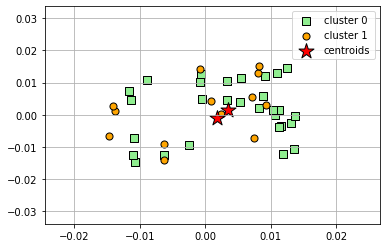

*************************** Start assigning cluster  Bruno Mars  -  Long Distance *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Long Distance *******************************************
["Long Distance, There's only so many songs that I can sing  \nTo pass the time  \n  \nAnd I'm running out of things to do  \nTo get you off my mind  \nOooh...  \n  \nAll I have is this picture in a frame  \nThat I hold close to see your face everyday  \n  \nWith you is where I'd rather be  \nBut we're stuck where we are  \nAnd it's so hard, you're so far  \nThis long distance is killing me  \n  \nI wish that you were here with me  \nBut we're stuck where we are  \nAnd it's so hard, you're so far  \nThis long distance is killing me  \n  \nIt's so hard, it's so hard  \nWhere we are, where we are  \nYou're so far  \nThis long distance is killing me  \nIt's so hard, it's so hard  \nWhere we are, where we are  \nYou're so far  \nThis long dist

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Marry You *******************************************
#Test output for words in word2vec
marri
beauti
night
look
someth
dumb
hey
babi
think
wanna
*************************** Start kmeans cluster  Bruno Mars  -  Marry You *******************************************
[[-1.6601437e-03  3.3207498e-03  6.9489353e-05  3.1302879e-03
   1.0498597e-03 -2.8310220e-03  4.4856304e-03  6.5953488e-04
  -2.7241139e-03 -1.9096716e-03 -7.8192819e-04 -7.2852283e-04
  -7.6347991e-04  1.8820865e-06  4.0557627e-03 -2.6392108e-03
   2.2702103e-03  6.8109814e-04  1.9047165e-03  2.9528926e-03
  -1.1751364e-03  3.2106671e-04  1.9988355e-03 -2.5446150e-03
  -7.6792215e-04 -1.1419428e-03  2.8769604e-03  2.1822187e-03
  -4.2215213e-03  1.6372406e-03 -9.1454980e-04 -9.6303888e-04]
 [-4.9601733e-03  4.9626906e-03  4.0098149e-03 -6.0102125e-03
   3.0781413e-04  1.2286911e-03 -4.9215681e-03 -5.9118087e-04
   1.7833803e-04 -4.8789836e-04  4.4328999e-03  2.

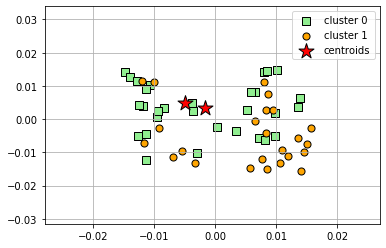

*************************** Start assigning cluster  Bruno Mars  -  Marry You *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Marry You *******************************************
["Marry You, It's a beautiful night, we're looking for something dumb to do  \nHey baby, I think I wanna marry you  \nIs it the look in your eyes, or is it this dancing juice  \nWho cares baby, I think I wanna marry you  \n  \nWell I know this little chapel on the boulevard  \nWe can go  \nNo one will know  \nOh c'mon girl  \n  \nWho cares if we're trashed  \nGot a pocket full of cash we can blow  \nShots of Patron  \nAnd it's on girl  \n  \nDon't say no no no no no  \nJust say yeah yeah yeah yeah yeah  \nAnd we'll go go go go go  \nIf you're ready, like I'm ready  \n  \n'Cause it's a beautiful night, we're looking for something fun to do  \nHey baby, I think I wanna marry you  \nIs it the look in your eyes or is it this dancing juice  \nWho cares

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 0.0
fun 0.0
get 0.0
ring 0.0
let 0.0
choir 0.0
bell 0.0
sing 0.0
ooh 0.0
run 0.0
wake 0.0
want 0.0
break 0.0
cool 0.0
blame 0.0
tell 0.0
right 0.0
        words                                            vectors  cluster  \
0       marri  [0.010100053, 0.014715932, -0.015054306, 0.009...        0   
1      beauti  [-0.013190126, -0.0032313312, -0.00042144564, ...        1   
2       night  [-0.014695654, 0.0056828684, -0.01016576, -0.0...        1   
3        look  [-0.0029458913, -0.010088695, 0.011963423, 0.0...        0   
4      someth  [0.008024409, 0.014149071, -0.0047473726, -0.0...        0   
5        dumb  [-0.011228999, -0.0046135364, 0.015146347, 0.0...        0   
6         hey  [-0.009528723, 0.00064637506, -0.00509922, 0.0...        0   
7        babi  [0.0034941914, -0.0035801507, 0.014538855, 0.0...        0   
8       think  [0.0002483804, -0.0025091723, 0.007904649, -0....        0   
9       wanna  [0.0072496748, -0.0055694752, 0.015139596, -0....        0   
10   

*************************** Start vectorization  Bruno Mars  -  Move On *******************************************
#Test output for words in word2vec
move
whooo
whoooo
end
old
place
face
mistak
stubborn
thinkin
*************************** Start kmeans cluster  Bruno Mars  -  Move On *******************************************
[[ 1.0162576e-03 -2.1081301e-03 -2.8170566e-03  7.6039578e-06
   1.5475329e-03  2.3595814e-04  2.3832214e-03  2.9077986e-04
   3.2225051e-03 -3.6811307e-03  2.6975058e-03  1.7117234e-03
  -1.4688035e-03 -3.5729115e-03 -3.8813327e-03  1.8341551e-03
   2.2892556e-03  1.0678932e-03 -1.4589995e-04 -3.3039590e-03
   2.4475326e-04  1.9965941e-04  8.7197521e-05  4.9991049e-03
   8.2651526e-04  2.0601938e-03 -2.2491871e-04  1.4925211e-03
  -8.2942250e-04 -2.2085346e-03 -1.5124273e-03 -2.9282230e-03]
 [ 6.5057131e-05  3.5108957e-03  8.4932812e-04  1.7104107e-03
   3.2731304e-03  4.0911948e-03 -1.5073675e-03  3.9261919e-03
  -3.7253425e-03 -1.5833804e-03  4.6686027e-03  2.

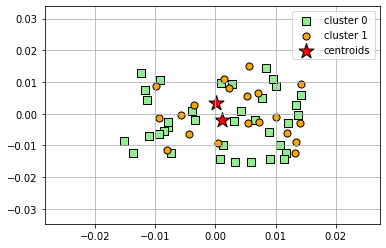

*************************** Start assigning cluster  Bruno Mars  -  Move On *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Move On *******************************************
['Move On, (Whooo whoooo)  \nHow do I end up in the same old place,  \nFaced again with the same mistakes,  \nSo stubborn thinkin I know what is right,  \nBut life proves me wrong everytime,  \nTakin roads that lead me nowhere,  \nHow do I expect to get there,  \nBut when will I learn to just put you first.', '[Chorus:]  \nI come to you now when I need you,  \nBut why do I wait to come see you,  \nI always try to do this on my own but I was wrong cause only with you can I\nmove on.', 'Can I move on.', "(Oh)  \nWhen I awake it's you that makes  \nMe strong,  \nAnd I know that you've been with me all along,  \nSo many times I begin to close my eyes and listen to my heart,  \nWith you life is so easy why do I  \nMake it hard,  \nOh takin' roads that lead

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Nothin On You *******************************************
#Test output for words in word2vec
nothin
beauti
girl
world
could
chase
time
would
wast
got
*************************** Start kmeans cluster  Bruno Mars  -  Nothin On You *******************************************
[[ 1.0176734e-03 -2.6027858e-03 -7.4181595e-04  3.3332163e-03
  -9.0463663e-04  8.6212019e-04  4.7843745e-03 -5.3387118e-04
   8.3762873e-04 -2.8787418e-03 -2.2414220e-03  1.6413552e-03
  -3.0779385e-04  2.2733312e-03  1.9088314e-03  1.2284098e-04
   2.0648635e-03 -2.2044105e-03  1.4357199e-03  2.0331470e-04
  -2.3235481e-03 -9.6860400e-05  1.8533779e-04 -1.6287229e-03
  -5.5104040e-04  1.8237296e-03  5.1330016e-03  1.9373061e-03
  -3.3905654e-04 -2.6669592e-04 -1.8243121e-03 -5.5101784e-03]
 [-1.0401687e-03  2.1220748e-03  1.7158771e-03 -2.6058520e-03
   1.3338658e-03 -1.5618999e-03 -3.8039996e-03  2.4959000e-03
  -3.3480802e-03 -1.2370967e-04  4.3088449

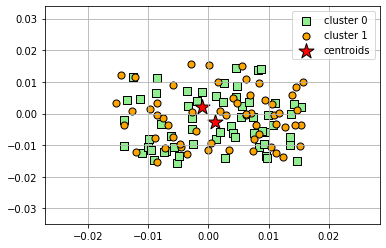

*************************** Start assigning cluster  Bruno Mars  -  Nothin On You *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Nothin On You *******************************************
["Nothin On You, Beautiful girls all over the world  \nI could be chasing but my time would be wasted  \nThey got nothin' on you baby  \nNothin' on you baby  \n  \nThey might say hi and I might say hey  \nBut you shouldn't worry about what they say  \n'Cause they got nothin' on you baby  \nNothin' on you baby  \n  \nNo' no' no' nothin' on you babe  \nNo' no' nothin' on you  \nI know you feel where I'm coming from  \nRegardless of the things in my past that I've done  \nMost of it really was for the hell of the fun  \nOn the carousel so around I spun (spun)  \nWith no directions just tryna get some (some)  \nTryna chase skirts, living in the summer sun (sun)  \nAn' so I lost more than I had ever won  \nAnd honestly I ended up with none  \n 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


      words                                            vectors  cluster  \
0    nothin  [0.0026618063, 0.009802333, 0.0011097252, 0.01...        0   
1    beauti  [-0.012924203, -0.0035109743, -0.0005550093, -...        1   
2      girl  [-0.0036324644, 0.007967791, 0.0055446816, -0....        1   
3     world  [-0.008592425, 0.01120355, -0.008269742, -0.01...        0   
4     could  [0.00079667073, -0.01274592, -0.015555811, 0.0...        1   
..      ...                                                ...      ...   
114      ha  [-0.00044331947, 0.0062817936, -0.0026953004, ...        1   
115    ride  [0.0012008556, 0.014766296, 0.015596862, 0.013...        1   
116       b  [-0.010449288, -0.004568754, -0.010810563, -0....        1   
117   bruno  [-0.0027807758, -0.0013445489, 0.008487965, -0...        0   
118     mar  [-0.00045793576, -0.00846151, 0.011848449, -0....        1   

     cluster_value  closeness_score  sentiment_coeff  tfidf_weights  
0                1        19.

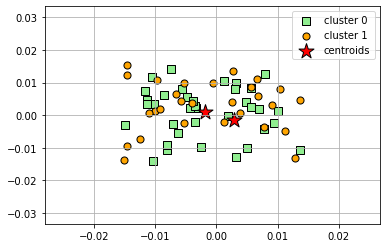

*************************** Start assigning cluster  Bruno Mars  -  On Fire *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  On Fire *******************************************
["On Fire, Oh (oh) Oh (oh) Ohhhh  \nOh (oh) Oh (oh oh)  \nKeep crawling up touchin' ya', kissin' ya', lovin' ya'  \nThe ice is melting down your back  \nCause there's a flame between us  \nGirl with every single touch  \nIt's like your body strikes a match  \nI' ma need to  \nStop (stop)  \nDrop (drop)  \nAnd roll (roll)  \nCause baby girl your heat's out of control  \nFeels like I'm on fire (fire)  \nMy body's a 100 degrees  \nEvery time you're standing next to me  \nFeels like I'm on fire (fire)  \nGirl you make me so hot  \nI don't want it to stop, no  \nOh, you got me burning up  \n(Oh-oh) burning up  \n(Oh-oh) burning up (oh-oh) oh  \nSo turn it up (oh-oh) turn it up  \n(Oh-oh) some more  \nFeels like I'm on fire (fire)  \nMy temperature is highe

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


    words                                            vectors  cluster  \
0    fire  [0.0044870186, 0.013719187, 0.015799759, -0.00...        1   
1      oh  [0.0030022543, 0.009043485, -0.0022113663, 0.0...        1   
2   ohhhh  [-0.005681108, 0.007966183, 0.0017148481, 0.01...        0   
3    keep  [-0.0025504602, -0.0096396115, -0.010379312, -...        0   
4   crawl  [0.0031540766, -0.012855375, 0.009516812, 0.00...        0   
..    ...                                                ...      ...   
60   oooh  [0.013584167, -0.010604575, 0.012414202, -0.00...        0   
61  knock  [-0.004777056, 0.011188039, 0.015470965, -0.00...        1   
62   door  [-0.013860812, -0.015033028, 0.014455755, -0.0...        1   
63   give  [-0.008128745, -0.009194358, -0.0085737975, 0....        0   
64   ohhh  [-0.004789164, 0.005446169, -0.012497017, -0.0...        0   

    cluster_value  closeness_score  sentiment_coeff  tfidf_weights  
0              -1        17.994574       -17.994574   

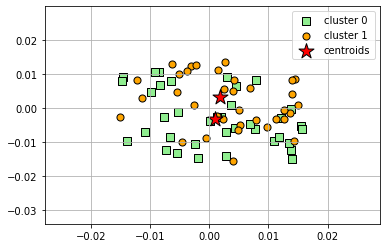

*************************** Start assigning cluster  Bruno Mars  -  Press It *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Press It *******************************************
["Press It, It's been so long since you been gone,  \nAnd now we're here  \nThe music's on,  \nWe're feeling freaky (oh)  \nI want you in my bedroom,  \nYou want me closer to you  \nWhat are we doing?", "Let's get to it  \n  \nI lay you down,  \nTake off your clothes,  \nThen kiss your lips  \nIt feels so good, ooh you're saying more  \nI wanna be inside you  \nOoh girl you got that fire  \nI can't wait no longer  \nI just gotta take control  \n  \nThe lights in the club are turning you on  \nNow girl let's pretend we both are alone  \nWe'll finish this up when we get home  \nThe only thing I need from you girl  \n  \nIs to press your body,  \nOn my body  \nDo it fast, do it slow,  \nYou control the tempo  \n  \nLook over your shoulder  \nBring it b

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Starting Today *******************************************
#Test output for words in word2vec
start
today
date
stood
tri
call
pick
see
forgot
plan
*************************** Start kmeans cluster  Bruno Mars  -  Starting Today *******************************************
[[ 0.00130707 -0.00468089 -0.0018065  -0.0007215   0.00318363  0.00590034
  -0.00557888  0.00316515 -0.0028122  -0.00523026  0.00073622  0.00225162
  -0.000352    0.00259235  0.00346991  0.00331404  0.00323345 -0.0003371
  -0.00048135 -0.00480684 -0.00210096 -0.00100796  0.00121123 -0.00026783
   0.00130766 -0.00052143  0.00107261 -0.00559322 -0.00115438  0.00330327
  -0.00086759 -0.00065326]
 [-0.00133176  0.00058851 -0.00071613  0.00214227 -0.00373701 -0.00180847
   0.00178138 -0.00049349 -0.0009394   0.00143985  0.00066521  0.00089112
   0.00126307 -0.00300333 -0.00331175 -0.00481138  0.00092283 -0.00079433
   0.00143541  0.00627551  0.00108765  0.003573

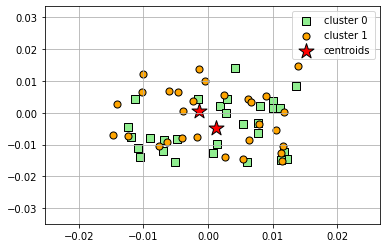

*************************** Start assigning cluster  Bruno Mars  -  Starting Today *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Starting Today *******************************************
["Starting Today, We had a date, I stood you up  \nYou tried to call but I didn't pick up  \nSee I forgot about our plans..", "Please forgive your man for ruining your night so many times  \nI'm sorry, I know you're mad  \nAnd I don't wanna be like every other man that you've had  \nSo I'm stopping all these childish things, girl, you mean too much to me  \nYour love is worth too much to lose  \nGirl, I know I broke your heart and trusting me is really hard  \nBut watch how quick I change my ways..", "Starting today, starting today  \nI know that I'm the one to blame, you say every man's the same  \nBut watch how quick I change my ways..", "Starting today, starting today  \nGirl, I'm starting today..  \nYou're tired of playing the kiss a

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[-1.5525341e-03  2.5224867e-03 -3.2275035e-03  3.2526148e-03
  -3.9513670e-03 -4.2817346e-03 -8.2113140e-04  1.1510539e-03
   3.5280152e-04 -8.8035059e-04 -1.2857980e-03 -6.3766143e-05
   1.8554373e-03  1.7195374e-03 -9.0639980e-04 -2.2681290e-03
  -9.3887775e-04  5.1979034e-05  1.4542553e-03  1.7260639e-03
   5.6025322e-04 -1.4898524e-03 -2.1883640e-03  6.6685030e-04
  -4.8358808e-04  2.1682854e-03  3.2076025e-03  7.0557268e-03
  -2.5984622e-04 -3.9929720e-03 -1.1091547e-03 -2.0182154e-03]
 [ 3.8785622e-03 -1.5576086e-03  7.6901829e-03 -9.5844525e-04
   2.8964668e-03 -1.4590264e-03 -7.2275574e-04 -1.1669325e-03
  -1.6215842e-03  6.3919066e-03  1.7667388e-03  2.1802611e-03
   1.7054693e-03 -3.1690474e-03  1.8043807e-03 -8.5728831e-04
   2.9780413e-04 -1.4176925e-03 -4.5082672e-04 -2.8957669e-03
   1.4044526e-03  1.7580943e-03  1.0577843e-03 -1.1349453e-03
  -4.2747980e-04 -4.3491833e-03 -7.6975033e-04 -6.5528126e-03
   4.2184378e-04  1.5280677e-03  9.6621719e-04 -9.3201548e-04]]


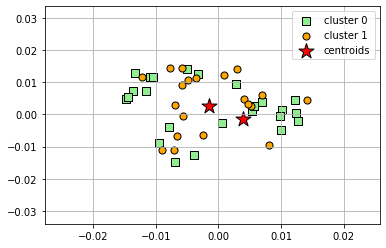

*************************** Start assigning cluster  Bruno Mars  -  Talking To The Moon *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Talking To The Moon *******************************************
["Talking To The Moon, I know you're somewhere out there  \nSomewhere far away  \nI want you back  \nI want you back  \nMy neighbors think I'm crazy  \nBut they don't understand  \nYou're all I have  \nYou're all I have  \n  \n[Chorus]  \nAt night when the stars  \nLight up my room  \nI sit by myself  \nTalking to the moon  \nTryin' to get to you  \nIn hopes you're on  \nThe other side  \nTalking to me too  \nOr am I a fool  \nWho sits alone  \nTalking to the moon  \n  \nOh  \n  \nI'm feeling like I'm famous  \nThe talk of the town  \nThey say I've gone mad  \nYeah I've gone mad  \nBut they don't know what I know  \n  \n'Cause when the sun goes down  \nsomeone's talking back  \nYeah they're talking back  \n  \n[Chorus]  \n  \n(

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  The Lazy Song *******************************************
#Test output for words in word2vec
lazi
song
today
feel
like
anyth
wanna
lay
bed
pick
*************************** Start kmeans cluster  Bruno Mars  -  The Lazy Song *******************************************
[[ 9.0966164e-04  1.7089185e-03 -1.4308221e-03 -5.1368866e-03
  -1.1106512e-03  6.0367596e-04 -1.7709958e-03 -3.1787143e-03
  -1.0002977e-03 -4.0998030e-03  9.8161679e-04 -6.1918120e-04
   4.8909779e-04 -6.2313594e-04  1.0283516e-03  3.3119172e-03
   1.3062582e-04  1.9634471e-03  3.7645800e-03 -2.6513962e-03
   4.3253149e-03 -2.5597117e-03 -2.1010505e-03 -1.4715645e-03
   2.8943585e-05  2.9807040e-04  3.5175728e-04 -2.5978326e-03
  -1.5731707e-03  6.8978312e-05 -4.6319873e-03  1.2216944e-05]
 [ 4.4257284e-04 -1.5436665e-03  3.6148529e-03  1.8688616e-03
   4.7334977e-03  2.7993377e-04 -2.0470156e-04  6.8356399e-04
  -1.1180423e-03  1.7422508e-03  1.5499824e-04  

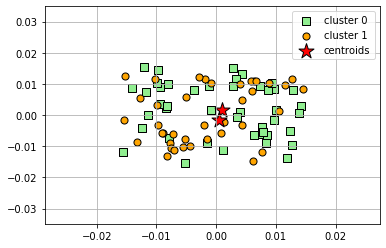

*************************** Start assigning cluster  Bruno Mars  -  The Lazy Song *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  The Lazy Song *******************************************
["The Lazy Song, Today I don't feel like doing anything  \nI just wanna lay in my bed  \nDon't feel like picking up my phone  \nSo leave a message at the tone  \n'Cause today I swear I'm not doing anything  \n  \nUh I'm gonna kick my feet up and stare at the fan  \nTurn the t.v.", "on  \nThrow my hand in my pants  \nNobody's gon' tell me I cant, no  \n  \nI'll be loungin' on the couch just chillin' in my snuggie  \nFlip to MTV so they can teach me how to Dougie  \n'Cause in my castle I'm the freakin' man  \nOh  \n  \nYes I said it  \nI said it  \nI said it 'cause I can  \n  \nToday I don't feel like doing anything  \nI just wanna lay in my bed  \nDon't feel like picking up my phone  \nSo leave a message at the tone  \n'Cause today I swear 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  The Other Side *******************************************
#Test output for words in word2vec
side
truth
matter
complic
straight
come
go
bout
day
babi
*************************** Start kmeans cluster  Bruno Mars  -  The Other Side *******************************************
[[ 2.6666047e-03  1.4187817e-03 -2.6133701e-03 -2.7524317e-03
  -1.1629870e-03 -8.4840623e-04 -1.5088246e-04  5.9048762e-03
   2.8491032e-03 -8.5449836e-04 -3.1950041e-03 -2.5837386e-03
   2.7490053e-03  3.0428891e-03  1.8828184e-03 -3.4525769e-04
   1.0234303e-03 -9.9008088e-05 -4.7681998e-03 -7.4704611e-03
   7.1578112e-04 -4.8346468e-03  2.6230845e-03  4.5663505e-03
  -1.4148554e-03 -3.3331756e-03 -1.7333607e-03  2.0338083e-03
  -2.5719539e-03 -5.1957536e-03 -2.0306148e-03  2.2835119e-03]
 [ 3.4388311e-03 -2.5729300e-05  8.6352538e-04  3.3414573e-05
   1.2320408e-04 -6.9104246e-04 -9.8048861e-04 -2.3711091e-03
  -9.4130624e-04 -1.7873856e-05  1.51047

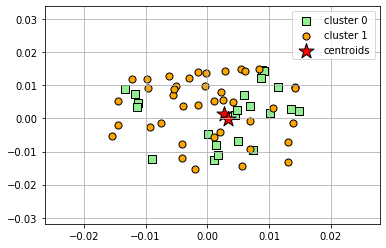

*************************** Start assigning cluster  Bruno Mars  -  The Other Side *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  The Other Side *******************************************
["The Other Side, Truth of the matter is I'm complicated  \nYou're as straight as they come  \nYou go 'bout your day baby  \nWhile I hide from the sun  \n  \nIt's better if you don't understand  \n'Cause you won't know what it's like  \nUntil you try  \n  \nYou know I, I'll be waiting on the other side  \nAnd you, all you gotta do is cross the line  \nI could wait a whole life time  \nBut you just gotta decide  \nYou know I, I'll be waiting on the other,  \nWaiting on the other side  \n  \nWe would live forever  \nWho could ask for more  \nYou could die if you wanted  \nBut baby what for  \n  \nIt's better if you don't understand  \nAnd you won't know what it's like  \nUntil you try  \n  \nYou know I, I'll be waiting on the other side  \

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 0.0
pay 0.0
       words                                            vectors  cluster  \
0       side  [-0.013196679, 0.01310815, -0.011977751, 0.001...        1   
1      truth  [0.0053673266, -0.014501159, 0.013174356, -0.0...        1   
2     matter  [0.009204417, -0.009627496, -0.0001486342, 0.0...        1   
3    complic  [0.0039257566, -0.0015697955, -0.013137104, -0...        1   
4   straight  [0.004445652, 0.0009564941, 0.011379022, -0.00...        0   
..       ...                                                ...      ...   
57     night  [-0.014335101, 0.005591095, -0.010465958, -0.0...        1   
58      back  [0.005996922, 0.0069771004, 0.013088203, -0.00...        0   
59      aliv  [-0.00898965, -0.012109132, 0.00012988907, -0....        0   
60     price  [-0.01330326, 0.008865714, 0.010349874, -0.001...        0   
61       pay  [0.0013840559, -0.008050483, -0.009183171, -0....        0   

    cluster_value  closeness_score  sentiment_coeff  tfidf_weights  
0    

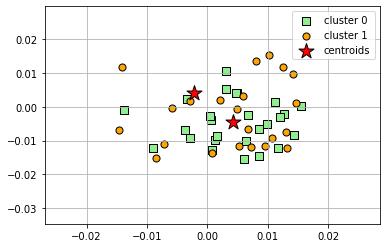

*************************** Start assigning cluster  Bruno Mars  -  This Is My Love *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  This Is My Love *******************************************
['This Is My Love, Now Hollywood wants to make you think they know what love is.', "But I'm a tell you what true love is.", 'Love is not what you see in the movies.', "It's not the ecstasy, it's not what you see in that scene  \nYou know what I mean?", "I'm telling you right now, true love is sacrifice.", "Always thinking my mind it's waiting for you if you crossing the  \nThis love is true, now are we alive  \nAnd I know that you gone, so gone  \nThe signs I got, this feeling  \nCause what I found, this is deeper than life  \nI know that I get lost in this feeling  \nI can see all in me, all in me, all in me  \n  \n[Chorus:] x 2  \nI'll put you in front of me  \nSo everybody can see  \nMy love, this is my love  \nI know that I'll be a

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[ 1.7814361e-04 -2.9409095e-04  1.3707164e-03  3.6123290e-04
   4.5312420e-03  5.2287476e-05 -1.4091760e-03  5.4231007e-03
  -1.3929188e-03 -3.6434401e-03  2.8165597e-03 -3.1861335e-03
   2.4438710e-03  1.6617762e-03 -4.5632711e-03  6.2319083e-04
   3.9441320e-03 -2.1121916e-03  2.1303431e-03 -4.3849030e-04
  -1.4089161e-03  2.6380208e-03  1.8672894e-04  1.6496952e-03
   4.5279916e-03 -2.8789719e-03  2.5253473e-03  1.7212814e-03
   1.8457748e-04  6.0829869e-04  6.8146049e-04  2.7064758e-03]
 [-2.5126059e-03 -6.1969139e-04  6.1232375e-04  2.1905522e-03
   8.3109178e-04  2.9962985e-03  3.6466958e-03 -4.4972659e-03
  -1.2350684e-03  2.4359056e-03  1.1155977e-03  3.9479313e-03
  -2.6851937e-03 -3.3693959e-03  2.2697044e-03 -2.6272687e-03
   4.3730242e-03  7.2551370e-03 -2.5773351e-03  9.1145589e-04
   2.1930521e-03 -5.4929056e-05 -5.8574963e-04 -4.4281632e-03
  -2.3104502e-03  7.1454537e-04 -1.6578423e-03 -2.4573908e-03
   2.3384900e-03  7.5430801e-04  2.9365811e-03 -4.5703808e-03]]


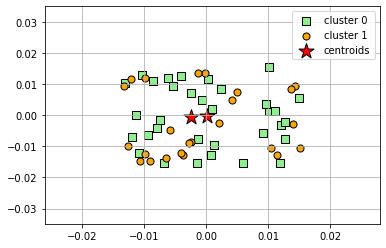

*************************** Start assigning cluster  Bruno Mars  -  Today My Life Begins *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Today My Life Begins *******************************************
["Today My Life Begins, I've been working hard so long  \nSeems like pain has been my only friend  \nMy fragile heart's been done so wrong  \nI wondered if I'd ever heal again  \n  \nOhh just like all the seasons never stay the same  \nAll around me I can feel a change (ohh)  \n  \nI will break these chains that bind me, happiness will find me  \nLeave the past behind me, today my life begins  \nA whole new world is waiting it's mine for the takin'  \nI know I can make it, today my life begins  \n  \nYesterday has come and gone  \nAnd I've learnt how to leave it where it is  \nAnd I see that I was wrong  \nFor ever doubting I could win  \n  \nOhh just like all the seasons never stay the same  \nAll around me I can feel a chan

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Top Of The World *******************************************
#Test output for words in word2vec
top
world
boy
bruno
imma
take
ya
girl
hey
readi
*************************** Start kmeans cluster  Bruno Mars  -  Top Of The World *******************************************
[[-6.4645294e-04 -1.5547726e-03 -1.1472855e-03 -1.1418097e-03
  -3.7676378e-03  5.3786900e-04 -4.5523071e-03  4.0476690e-03
  -2.5442718e-03 -6.3959220e-03  1.4138761e-03  6.6314026e-04
   2.9152900e-03  3.5678926e-03 -1.2477689e-03  3.3495139e-04
   2.9823053e-04  4.0098401e-03 -2.6904400e-03  8.1145309e-04
   1.9520089e-03  1.2776954e-03  4.8158143e-04  3.2153835e-03
  -3.3140648e-03 -2.5962908e-03 -3.6159193e-04  1.5521353e-03
  -4.0553184e-03 -4.5358781e-03  5.2507152e-05  2.3256987e-03]
 [-4.5798675e-04  2.9288367e-03  1.2694113e-03  2.3365831e-03
   2.9980335e-03 -1.4032902e-04  9.5538318e-04 -1.3248326e-03
   1.6147245e-03  2.0719706e-03  1.9591097e-0

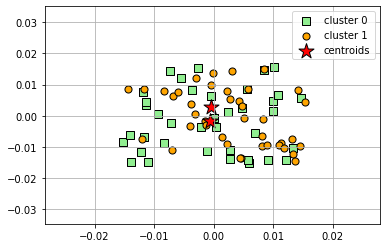

*************************** Start assigning cluster  Bruno Mars  -  Top Of The World *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Top Of The World *******************************************
["Top Of The World, It's your boy Bruno  \nImma take ya to the top girl, hey  \nTop of the world.", 'you ready?', "C'mon (let's go)  \n  \nI feel higher than the ceiling  \nCause I'm floating on this feelin'  \nSo long my feet have been up off the floor  \nDestiny is what I call it  \nMy Heart's for sale and girl you bought it  \nThe moment that you walk right through the door ooh  \n  \nTill the day that I stop livin'  \nGirl my love I won't stop givin'  \nCross my heart and hope to die my love is yours  \nAnd I pray girl that this feeling  \nIs something that we always feelin'  \nIf you're with it girl, hear me girl  \nThis is what I'll do  \n  \nI will give you the world  \nPut it in your hands  \nCause I ain't never felt this way

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[ 5.3024162e-03  1.0987275e-03  6.1299559e-03  1.2481003e-03
   2.1302181e-03 -2.7773485e-03 -2.0204722e-03 -6.9150277e-03
  -4.0607397e-03  7.0100906e-04 -3.9335195e-04  3.5139387e-03
  -2.3156884e-03 -1.1443354e-03  3.7162141e-03  5.3244410e-04
   8.1397319e-04 -7.9763737e-03 -3.2821163e-03 -2.9936291e-03
  -1.0596721e-03  3.2466208e-04 -3.6914325e-03 -1.2046676e-03
   1.1091307e-04 -4.1090127e-04  4.2446116e-03 -4.5631803e-03
   6.1206962e-04 -5.8427802e-05 -3.7016287e-03 -6.1598504e-03]
 [ 9.7876007e-04  3.4440190e-03  4.8380066e-04  1.1036855e-03
  -6.3245255e-04  4.7441404e-03  1.3964680e-03  4.5185992e-03
  -3.6099029e-04 -2.0259670e-03  1.2177411e-03  1.7004129e-03
   3.7063292e-04 -2.5733100e-04 -5.1863808e-03 -4.1409815e-04
   2.0732037e-03  5.8190031e-03  9.6383435e-04  3.5120291e-04
   1.6604181e-03  3.4491401e-03  2.6658501e-03  2.1239854e-03
  -4.5390351e-04 -2.3121098e-03 -1.3888315e-03  2.9259769e-03
   8.5951429e-04 -5.3357775e-04  3.2725926e-03  4.0162052e-04]]


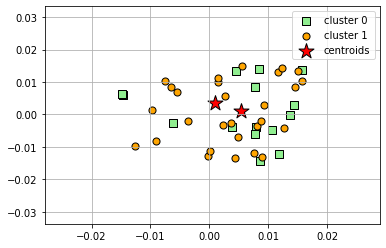

*************************** Start assigning cluster  Bruno Mars  -  Treasure *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Treasure *******************************************
["Treasure, Give me all, give me all, give me all your attention baby  \nI got to tell you a little something about yourself  \nYou're wonderful, flawless, oh you're a sexy lady  \nBut you walk around here like you wanna be someone else  \n  \nI know that you don't know it, but you're fine, so fine  \nOh girl I'm gonna show you when you're mine, oh mine  \n  \nTreasure, that is what you are  \nHoney you're my golden star  \nYou know you can make my wish come true  \nIf you let me treasure you  \nIf you let me treasure you  \n  \nPretty girl, pretty girl, pretty girl you should be smiling  \nA girl like you should never live so blue  \nYou're everything I see in my dreams  \nI wouldn't say that to you if it wasn't true  \n  \nI know that you don't kn

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Test output for words in word2vec
turn
around
vers
know
seem
like
everi
night
pick
fight
*************************** Start kmeans cluster  Bruno Mars  -  Turn Around *******************************************
[[-3.6410068e-04  1.3352097e-03  2.1791346e-03 -4.1488762e-04
  -4.6608271e-03  1.5620637e-04  5.0317454e-03  6.2409788e-05
  -2.0398626e-03 -4.5528088e-04 -3.7627597e-03 -1.1583173e-03
  -4.7728675e-04 -2.4592956e-03  1.0365223e-03 -3.8728539e-03
   5.0389470e-04 -2.6776670e-03  2.9448671e-03  4.4205924e-03
   4.0706131e-05 -1.7925724e-03  1.0106888e-03 -4.5588845e-03
  -1.5356059e-03 -2.4572858e-03  3.9183507e-03 -8.5041206e-04
  -5.5867401e-03 -2.1267487e-03  1.2944136e-03 -3.4842961e-03]
 [-1.5648815e-03 -3.2937923e-03 -3.4484449e-03 -7.8141491e-04
   2.5237808e-03  1.8484766e-03 -3.5906811e-03  5.4049026e-03
  -2.3411422e-03 -6.8340276e-04  9.4839314e-04  8.0744788e-04
   3.7744553e-03  4.4436968e-04 -6.6435151e-04 -1.3281922e-03
   2.0423443e-03  2.8314113e-03 -9.1774896e-

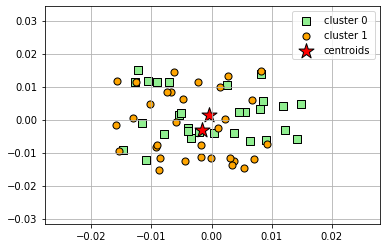

*************************** Start assigning cluster  Bruno Mars  -  Turn Around *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Turn Around *******************************************
["Turn Around, [Verse:]  \nI, I, I don't know why why  \nIt seems like every other night you pick a fight, fight  \nAnd I know I do the same, be callin' you out your name,  \nThis is not what lovers are supposed to do do  \n  \n[Pre-Chorus:]  \nYou tell me to go, I start walking out  \nBut we both know what we're all about  \nWe fuss, fight, and scream  \nAnd it's all because of love  \nBut you and I both of we ain't ever giving up  \n  \n[Chorus:]  \nEverytime I try to leave  \nSomethin's tells me turn around  \n'Cause how could I ever leave  \nThe only one that holds me down  \n'Cause I know we can work it out  \nTalk it out, stick it out oohh  \nEverytime I try to leave  \nFind that we can figure it out  \nThat's why I always turn around  \

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Valerie *******************************************
#Test output for words in word2vec
valeri
well
sometim
go
look
across
water
think
thing
head
*************************** Start kmeans cluster  Bruno Mars  -  Valerie *******************************************
[[-1.4498319e-03  6.0541928e-04  4.8029755e-04 -1.8757574e-03
  -6.2506995e-04  1.4768959e-03  2.0515844e-03 -5.6398363e-04
   3.4326431e-04 -1.4751173e-03  7.3244784e-04  7.4792246e-05
  -5.1099510e-04 -9.3513692e-04  3.7106271e-03  2.7017985e-03
   2.8906134e-03 -6.7401445e-05 -3.4144334e-04 -4.0839142e-03
   1.1940579e-03 -2.1135476e-03  3.8440148e-03 -2.7908236e-03
  -2.5781642e-03 -1.1713961e-03  5.8169272e-03  1.9329392e-03
   2.1930726e-03  2.7657212e-03 -8.9948170e-04 -2.7674515e-04]
 [ 2.3658099e-03 -4.2819171e-03  1.5079053e-03  3.9603077e-03
  -3.0322885e-04 -1.1533076e-03 -6.5792385e-03  1.5714960e-04
   4.3520052e-03  5.4575354e-03 -1.6329698e-03 -1.137

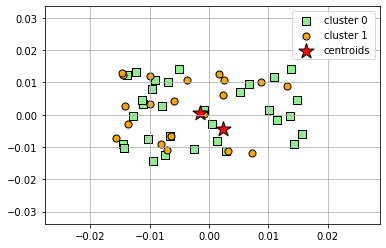

*************************** Start assigning cluster  Bruno Mars  -  Valerie *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Valerie *******************************************
["Valerie, Well sometimes I go out by myself  \nAnd I look across the water  \nAnd I think of all the things what you're doing  \nAnd in my head I paint a picture  \n  \n'Cause since I've come on home  \nWell my body's been a mess  \nAnd I've missed your ginger hair  \nAnd the way you like to dress  \n  \nWon't you come on over  \nStop makin?", "A fool out of me  \nWhy don't you come on over valerie?", 'Valerie valerie valerie  \n  \nDid you have to go to jail  \nPut your house on up for sale  \nDid you get a good lawyer?', "Hope you didn't catch a tan  \nHope you find the right man  \nWho'll fix it for you  \nAre you shopping anywhere  \nChanged the color of your hair  \nAre you busy?", 'And did you have to pay that fine  \nYou was dodging all the ti

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Voices In My Head *******************************************
#Test output for words in word2vec
voic
head
alon
room
wait
phone
ring
come
home
someday
*************************** Start kmeans cluster  Bruno Mars  -  Voices In My Head *******************************************
[[ 1.5750676e-03  1.8458205e-03  2.5737989e-03 -1.2578560e-03
   2.8951516e-04  5.3801984e-03  6.0196463e-03  6.6204742e-04
   5.8124866e-04 -1.4489100e-03 -1.0370973e-03  1.1733313e-03
  -2.8327820e-03 -1.2670883e-03 -7.1271160e-04  9.8708924e-04
  -4.9176868e-03 -2.7203897e-04  1.9158190e-03  1.3426188e-03
  -4.3598739e-03  1.8701272e-04 -1.9176065e-03  4.7006784e-04
   7.5289840e-03 -3.7808758e-03  3.4017372e-03 -1.2409128e-03
  -2.2522765e-03  1.9908434e-04  3.2410375e-04  3.5221898e-04]
 [ 1.3829770e-03 -2.8677243e-03  2.3705116e-04  1.8317243e-03
  -7.1098085e-04 -5.8638528e-03 -3.0142227e-03 -2.0919442e-03
   2.1899501e-03  2.8469914e-03  5.15

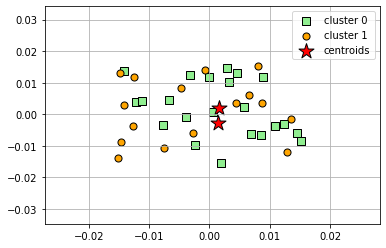

*************************** Start assigning cluster  Bruno Mars  -  Voices In My Head *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Voices In My Head *******************************************
["Voices In My Head, All alone in my room  \nWaiting for, for this phone to ring  \nShe'll come home someday soon  \nI just know or am I imagining things  \nThe voices in my head keep saying  \n(The voices in my head)  \nShe's coming back to you  \n  \nIs it strange that I talk to myself (oh oh oh oh oh oh)  \nIs it weird when I hear someone else (oh oh oh oh oh oh)  \nWhat do I do (what do I do)  \nThere's no more you (there's no more you)  \nAnd I tell me you'll be coming home (coming home)  \nIs it strange I believe them again (oh oh oh)  \nVoices in my head  \nThe voices, the voices, the voices  \nVoices in my head  \nThe voices (oh), the voices, the voices  \n  \nSomeone's there at the door  \nThis is her I just know (I just k

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Test output for words in word2vec
alright
young
run
free
stay
late
sleep
got
friend
night
*************************** Start kmeans cluster  Bruno Mars  -  We'll Be Alright *******************************************
[[-4.6580913e-03 -1.2295269e-03  1.7042730e-03 -4.2792578e-04
   2.8836443e-03 -9.7705820e-04 -1.9940431e-05  4.7605950e-05
   1.9277019e-03 -2.7926057e-03  1.3525685e-04  2.3838787e-03
   3.3983111e-04  1.4427277e-03 -3.6630682e-03 -1.1882230e-03
   1.0131239e-03 -8.1795943e-04  2.3951610e-03  3.0140122e-03
  -1.2830335e-03  2.3971410e-03  3.3955676e-03  4.8620786e-04
   4.5349589e-05  1.6304688e-03  2.1609154e-03 -3.7489487e-03
  -1.7422717e-06 -1.2170890e-03 -1.2488104e-05 -1.3574567e-03]
 [ 4.7227866e-03 -1.2381573e-03 -1.0645110e-03 -2.0034749e-03
  -1.1604471e-03 -5.6659372e-04  3.0805892e-03 -2.2806721e-03
  -5.2549550e-03  6.2184653e-04  1.3507237e-03 -3.6004933e-03
   2.6093209e-03  6.0927420e-04  2.7047980e-03  5.9514923e-04
   1.1269882e-04  4.6119215e-03 -5.539

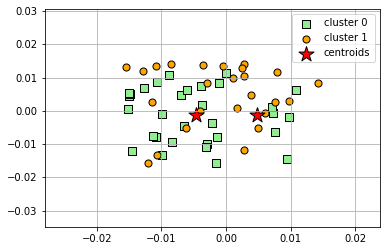

*************************** Start assigning cluster  Bruno Mars  -  We'll Be Alright *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  We'll Be Alright *******************************************
["We'll Be Alright, We are young, we run free  \nStay up late, we don't sleep  \nGot our friends, got the night  \nWe'll be alright  \n  \nTonight you won't be by your self-self  \nJust leave your problems on the shelf-shelf  \nYou won't wanna be nowhere else-else  \nSo let's go, so let's go (we got the club like)  \n  \n(Hoo-oo-oo-oo-oo-oo) and all the girls sayin'  \n(Hoo-oo-oo-oo-oo-oo) the whole world sayin'  \n(Hoo-oo-oo-oo-oo-oo) yeah, yeah, come on let's  \nGet drunk, toast it up, we don't give a fuck  \n  \nWe are young, we run free  \nStay up late, we don't sleep  \nGot our friends, got the night  \nWe'll be alright  \n  \nThrow our hands in the air  \nPretty girls everywhere  \nGot our friends, got the night  \nWe'll be alr

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Test output for words in word2vec
man
bed
feel
littl
bit
bigger
song
radio
sound
friend
*************************** Start kmeans cluster  Bruno Mars  -  When I Was Your Man *******************************************
[[-6.5427623e-04  1.0048181e-03  6.7593681e-04 -1.7951030e-03
  -2.4496971e-03  3.1843486e-03  5.8969267e-04  2.2581749e-04
   5.9737463e-04 -3.7119566e-03 -1.3568427e-03 -2.9139374e-03
  -1.3149908e-03 -9.9381281e-04 -1.7349554e-03  2.9451202e-03
   2.7513052e-03  2.4762342e-03 -7.4444833e-04 -8.4574602e-04
  -5.7053310e-04 -7.1525038e-04 -1.6363696e-03 -3.2938279e-03
  -1.1527434e-03 -4.3939939e-03  4.9838529e-04 -1.5734693e-03
  -1.3428936e-03 -3.4152297e-05 -3.2685236e-03 -4.4674966e-03]
 [ 2.6656600e-04  1.4185737e-03 -9.1300975e-04  4.5879977e-03
  -2.9966421e-04 -3.2676635e-03 -9.3633105e-04  1.4227165e-03
  -5.7066436e-04 -1.8616413e-03  2.6871536e-03  2.8374784e-03
   1.8342296e-03 -1.5697773e-03 -1.5313046e-03 -4.7255075e-03
  -3.1300718e-03 -2.3758863e-03  2.92

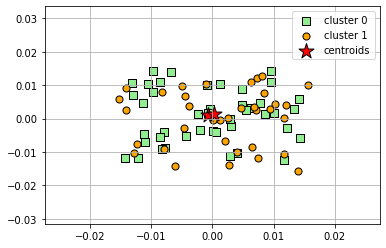

*************************** Start assigning cluster  Bruno Mars  -  When I Was Your Man *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  When I Was Your Man *******************************************
["When I Was Your Man, Same bed but it feels just a little bit bigger now  \nOur song on the radio but it doesn't sound the same  \nWhen our friends talk about you, all it does is just tear me down  \n'Cause my heart breaks a little when I hear your name  \n  \nIt all just sounds like ooh, ooh ooh hoo hoo  \nMm, too young, too dumb to realize  \nThat I should have bought you flowers  \nAnd held your hand  \nShould have given you all my hours  \nWhen I had the chance  \nTake you to every party 'cause all you wanted to do was dance  \n  \nNow my baby's dancing  \nBut she's dancing with another man  \n  \nMy pride, my ego, my needs, and my selfish ways  \nCaused a good strong woman like you to walk out my life  \nNow I never, neve

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  24K Magic *******************************************
#Test output for words in word2vec
k
magic
intro
tonight
want
take
higher
throw
hand
sky
*************************** Start kmeans cluster  Bruno Mars  -  24K Magic *******************************************
[[-1.3880783e-03  4.1620601e-03 -1.8141784e-04 -9.1657619e-04
  -2.5316235e-04  2.0803774e-03 -1.7704542e-03  2.4025100e-03
  -3.6627133e-03 -6.8787839e-03  2.4400635e-04  3.1798480e-03
  -7.8173087e-04  1.9888794e-03 -1.9744691e-03  3.5014376e-03
   6.9910492e-04  3.6503840e-03 -3.6097756e-03  1.8382014e-04
   1.9875907e-03  8.7236433e-04 -1.8740329e-04  2.1661703e-04
  -1.3243194e-03 -1.8308719e-03 -3.6462443e-04  2.5472203e-03
   9.3449507e-04  2.7231788e-03  1.4836490e-03  1.5103949e-03]
 [-1.8184376e-04 -2.5143886e-03 -2.4350447e-07 -8.9626195e-04
   2.3227348e-03 -2.1526224e-03  8.9235831e-04  9.6220797e-04
   3.1456763e-03  1.3750242e-03 -5.1055918e-04  5.286

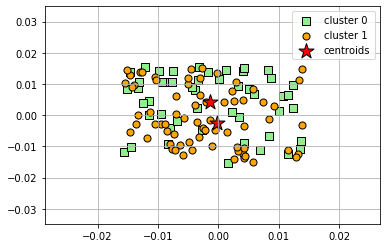

*************************** Start assigning cluster  Bruno Mars  -  24K Magic *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  24K Magic *******************************************
["24K Magic, [Intro]  \nTonight  \nI just want to take you higher  \nThrow your hands up in the sky  \nLet's set this party off right  \n  \n[Chorus]  \nPlayers, put yo' pinky rings up to the moon  \nGirls, what y'all trying to do?", '24 karat magic in the air  \nHead to toe soul player  \nUh, look out!', "[Verse 1]  \nPop pop, it's show time (Show time)  \nShow time (Show time)  \nGuess who's back again?", "Oh they don't know?", "(Go on tell 'em)  \nOh they don't know?", "(Go on tell 'em)  \nI bet they know soon as we walk in (Showin' up)  \nWearing Cuban links (ya)  \nDesigner minks (ya)  \nInglewood's finest shoes (Whoop, whoop)  \nDon't look too hard  \nMight hurt ya'self  \nKnown to give the color red the blues  \n  \n[Pre-Chorus]  \nOoh shit

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Again *******************************************
#Test output for words in word2vec
hand
head
think
el
could
go
wrong
would
stay
bed
*************************** Start kmeans cluster  Bruno Mars  -  Again *******************************************
[[ 2.9757610e-03  8.9935435e-05 -3.5015310e-03  4.8834202e-03
  -5.6887241e-03 -2.1725975e-03  4.3930998e-04  4.6642385e-03
   3.0759613e-03  1.0700744e-03  2.3623502e-03  2.8734440e-03
   3.1428582e-03  7.7056402e-04  7.1871205e-04 -1.5198828e-03
  -1.0774179e-03  1.9153425e-03  2.3331554e-03 -3.3571529e-03
   1.6588152e-03  1.5985237e-03  4.7451671e-04  4.0223300e-03
  -9.4969658e-04  2.3171271e-03 -3.3257336e-03  1.1174384e-03
  -4.3641921e-04 -2.0732065e-03 -3.7382059e-03  2.0242918e-03]
 [-1.2877228e-03 -2.0087496e-03  6.1353408e-03 -6.3668769e-03
   4.1343290e-03  9.9951983e-04 -6.5331295e-04 -3.5167453e-03
  -7.4460153e-03 -2.8504776e-03  1.9411065e-03 -2.7583160e-03
  -5

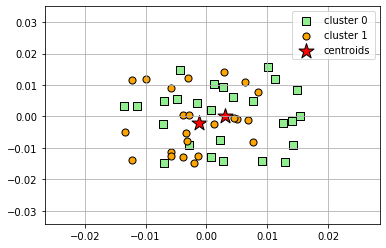

*************************** Start assigning cluster  Bruno Mars  -  Again *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Again *******************************************
["Again, Hands over my head thinking 'what else could go wrong? '", "Would've stayed in bed, how can a day be so long?", "Never believed that things happen for a reason  \nBut how this turned out removed all my doubts, so believe  \nThat for you I'll do it all over again  \nDo it all over again  \nAll I went through, led me to you  \nSo I'd do it all over again  \nFor you  \n  \nI missed the first train, stood out in the rain, all day  \nLittle did I know  \nWhen I caught the next train, there you were to sweep me away  \nGuess that's what I've waited for  \nNever believed that things happened for a reason  \nBut how this turned out, you moved all my doubts, So believe  \nThat for you I'd do it all over again  \nDo it all over again  \nAll I went through,

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[-2.39790045e-03 -4.30759508e-03 -6.54460303e-03  1.61080493e-03
  -1.44747854e-03 -6.82026986e-03  3.93668190e-03  1.81617390e-04
  -1.00286957e-03 -9.32753552e-04  2.13682908e-03  4.60858131e-03
   4.26594401e-04 -4.48808540e-03 -3.60786822e-03 -8.19743425e-03
   9.46564716e-04  6.39224285e-03 -9.62268445e-04 -2.07843864e-03
  -4.90353722e-03  2.10474152e-03 -2.68093962e-03  1.35793863e-03
  -3.02882399e-03  2.01716321e-03  6.48104236e-04  3.39638093e-03
   5.49774291e-03 -3.39073944e-03  2.63312948e-03 -1.75012683e-03]
 [ 3.56927607e-03  2.00891728e-03  2.27331184e-03  1.54508068e-03
   1.80663541e-03  3.75290168e-03  2.01678206e-03 -1.66059495e-03
   3.29986797e-04 -3.71736288e-03  8.54383630e-04  2.16741604e-03
  -3.38974496e-05 -6.23252010e-04  3.30616185e-03  3.64412833e-03
   2.20856210e-03 -1.37855881e-03  2.38680048e-03  7.94372289e-04
  -6.41910476e-04  1.07798853e-03 -7.39650801e-04  2.19620881e-03
   3.86529882e-03  2.59971945e-03  4.57691145e-04 -1.55605888e-03
  -2.2622

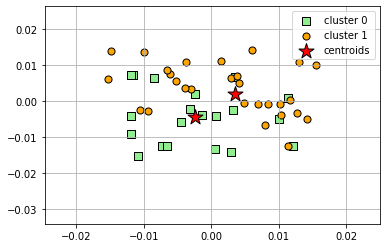

*************************** Start assigning cluster  Bruno Mars  -  All She Knows *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  All She Knows *******************************************
["All She Knows, Once again you're home alone  \nTears running from your eyes  \nAnd I'm on the outside  \nKnowing that you're all I want  \nBut I can't do anything  \nI'm so helpless baby  \n  \nEveryday same old things  \nSo you're still feelin' pain  \nNever had real love before  \nAnd it ain't her fault  \n  \nShe knows better but  \nShe can't help it  \nWanna tell her  \nBut would that be selfish  \nHow do you heal  \nA heart that can't feel, it's broken  \nHis love is all she knows, all she knows, all she knows  \nHis love is all she knows, all she knows, all she knows  \n  \nYou've been livin' this way so long  \nYou don't know the difference  \nAnd it's killing me  \nCause you can have so much more  \nI'm the one your looking for  

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[ 2.3360418e-03 -7.1499022e-03 -2.4773888e-03 -2.3858850e-03
  -2.0786093e-03 -8.7567058e-04  3.4319598e-03 -2.7111666e-03
  -1.2163452e-03 -3.2628535e-03 -1.3509933e-03 -1.8645884e-04
   7.4558397e-04 -5.3659682e-03  1.3650671e-03 -2.9013189e-03
   9.2976494e-05  1.3847041e-04  2.5252316e-03  1.7040863e-03
  -8.7081699e-04  6.0771516e-04 -1.7102200e-03 -3.8463646e-04
  -1.9161066e-03  4.0115039e-03  5.1841610e-03 -4.3369987e-04
   4.9968949e-03 -7.3300335e-03  3.0397871e-03 -2.9621311e-03]
 [ 1.8107870e-03  3.5872422e-03  4.0251263e-03  9.8450342e-05
  -9.6415338e-04 -2.7860187e-03 -2.5087078e-03  2.0244389e-03
  -2.3975942e-04 -5.9534039e-04  3.7740795e-03 -6.5868249e-04
   2.0913515e-04  4.6016122e-03 -7.6867023e-04  1.4372275e-03
   3.9194785e-03  5.8958423e-04 -2.6629502e-03 -3.7348047e-03
   6.7386893e-05  1.8669695e-03 -2.3628067e-04  4.0311543e-03
  -1.7864929e-03  2.2075262e-03 -1.7765921e-03 -7.9492840e-04
   1.4678073e-03  6.3140718e-03 -1.2387983e-03 -2.8219051e-04]]


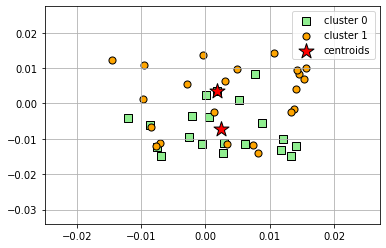

*************************** Start assigning cluster  Bruno Mars  -  Before It Explodes *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Before It Explodes *******************************************
["Before It Explodes, It's not a question of love,  \nCause our love has never changed.", 'But all the little things keep piling up,  \nAnd life keeps getting in the way.', "Don't make this harder than it is,  \nWe both knew it'd come to this.", 'Better now than in a year,  \nWith lots of tears,  \nAnd we both hate each other.', 'The fuse has already left,  \nSo how about a final kiss?', 'And just let it go.', 'Stop the madness,  \nBefore it explodes!', "Before it's out of our control.", "Let's stop the madness,  \nBefore it explodes!", 'We gotta let it go,  \nBefore it all explodes.', "Some things we won't understand,  \nAnd we're both so tired of being misunderstood.", "So let's just turn and walk away,  \nAnd hold on to what w

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[-6.5393571e-04 -1.7111084e-03 -3.5182375e-03 -8.0808089e-04
  -1.3537700e-03 -1.5223331e-03  5.0598038e-03  1.2853829e-03
   1.1311518e-03 -4.3227016e-03  1.2862756e-03 -3.5938872e-03
  -4.7894550e-04  1.9733780e-03  3.9644248e-04 -1.4605958e-03
   2.6457685e-03 -1.5181015e-03  9.0188812e-04  1.1083665e-03
   3.9682479e-04 -1.8818543e-03  3.2971392e-04 -9.4685063e-04
   1.7297503e-03  2.6379640e-03  3.1039559e-03 -7.1635644e-04
   1.1190856e-03  3.6078400e-04  4.3156254e-04 -1.0767542e-03]
 [ 6.6576351e-04  2.0440791e-03  2.6794062e-03 -7.6882163e-04
   1.6630435e-04  2.4589298e-03 -5.1718424e-03 -1.8288691e-03
  -2.7533048e-03  3.2951022e-03 -1.7452348e-03  4.0650270e-03
  -4.0164028e-04 -4.0913876e-03 -1.7637962e-03 -4.4709479e-05
   1.0229208e-03  2.0210606e-03  4.6777009e-04 -4.4075884e-03
  -1.9699358e-03  3.2872232e-03 -4.7975266e-04 -1.6605086e-04
  -5.4657698e-04 -1.4075343e-03 -3.1293673e-03  4.3687411e-05
  -7.1911194e-04  1.3952696e-04  4.5436199e-04 -2.1861484e-03]]


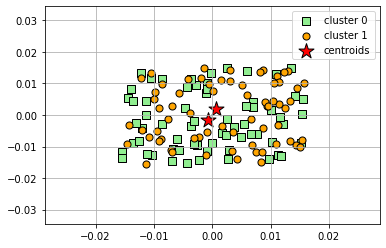

*************************** Start assigning cluster  Bruno Mars  -  Billionaire *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Billionaire *******************************************
["Billionaire, I wanna be a billionaire so freakin' bad  \nBuy all of the things I never had  \nUh, I wanna be on the cover of Forbes magazine  \nSmiling next to Oprah and the Queen  \n  \nOh every time I close my eyes  \nI see my name in shining lights  \nYeah, a different city every night oh right  \nI swear the world better prepare  \nFor when I'm a billionaire  \n  \nYeah I would have a show like Oprah  \nI would be the host of, everyday Christmas  \nGive Travie a wish list  \nI'd probably pull an Angelina and Brad Pitt  \nAnd adopt a bunch of babies that ain't never had shit  \nGive away a few Mercedes like here lady have this  \nAnd last but not least grant somebody their last wish  \nIt's been a couple months that I've been single so  \

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 0.0
bunch 0.0
babi 0.0
shit 0.0
away 0.0
merced 0.0
ladi 0.0
last 0.0
least 0.0
grant 0.0
somebodi 0.0
coupl 0.0
month 0.0
singl 0.0
call 0.0
clau 0.0
minu 0.0
ho 0.0
get 0.0
hehe 0.0
visit 0.0
katrina 0.0
hit 0.0
damn 0.0
sure 0.0
lot 0.0
fema 0.0
forget 0.0
stupid 0.0
everywher 0.0
go 0.0
imma 0.0
theme 0.0
music 0.0
ooh 0.0
play 0.0
basketbal 0.0
presid 0.0
dunk 0.0
deleg 0.0
compliment 0.0
polit 0.0
etiquett 0.0
toss 0.0
milli 0.0
air 0.0
heck 0.0
keep 0.0
five 0.0
twenti 0.0
ten 0.0
ben 0.0
complet 0.0
separ 0.0
whole 0.0
new 0.0
tax 0.0
bracket 0.0
recess 0.0
let 0.0
take 0.0
crack 0.0
whatev 0.0
left 0.0
split 0.0
everybodi 0.0
love 0.0
buck 0.0
tummi 0.0
around 0.0
know 0.0
hungri 0.0
eat 0.0
good 0.0
sleep 0.0
soundli 0.0
similar 0.0
dream 0.0
pocket 0.0
wallet 0.0
put 0.0
sing 0.0
fuckin 0.0
          words                                            vectors  cluster  \
0    billionair  [0.013267062, -0.010559463, 0.0099880025, 0.00...        1   
1         wanna  [0.00774417

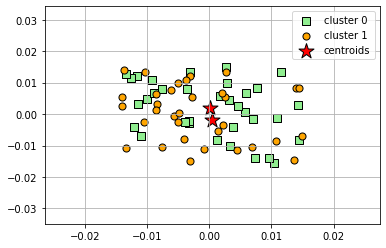

*************************** Start assigning cluster  Bruno Mars  -  Chunky *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Chunky *******************************************
["Chunky, [Verse 1]  \nShe got to shake her little something  \n(Shake her little something)  \nThrowing that thing from left, right, side to side  \nShe got to have her own money  \n(She got her own money)  \nShout out to the girls that pay they rent on time  \n  \n[Pre-Chorus]  \nIf you ain't here to party take your ass back home  \nIf you getting naughty, baby here's my phone  \nSlide with your boy to the bar  \nSlide with your boy to the car  \nI've been searching everywhere and now here you are  \n[Chorus]  \nChunky  \nLooking for them girls with the big old hoops  \nThat drop it down in daisy dukes  \n(I wanna get down)  \nYeah, I am the one, I'm trying to recruit  \nI'm looking at you  \nYeah, you baby  \n  \n[Verse 2]  \nNow let me hear you say 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Count On Me *******************************************
#Test output for words in word2vec
count
ever
find
stuck
middl
sea
sail
world
lost
dark
*************************** Start kmeans cluster  Bruno Mars  -  Count On Me *******************************************
[[-3.2292842e-04 -1.2218149e-03  9.8121422e-04  4.0547526e-03
  -2.7574711e-03  2.9873749e-04  1.2947441e-03 -1.9537546e-03
  -1.4014206e-03  4.2415643e-03  5.5143202e-04 -6.5449078e-04
  -2.4026232e-03 -2.9275131e-03 -1.4074880e-03 -4.4154394e-03
   1.1663189e-03  1.1637876e-03  2.1615828e-04  4.6465462e-03
  -2.0224045e-04 -2.6021604e-03 -9.1288122e-04 -6.8701273e-03
  -2.7481730e-03 -4.9085403e-03  3.0785189e-03 -2.0878606e-03
   9.5161702e-04 -1.5869763e-03 -1.6833507e-03 -6.1329985e-03]
 [-1.4683219e-03  3.7722781e-03 -3.4436646e-03 -2.3118868e-03
  -9.2925347e-04  1.8042447e-03 -2.3271397e-03  4.2148610e-03
   6.2887906e-04 -1.5912729e-03  2.2120811e-03  5.

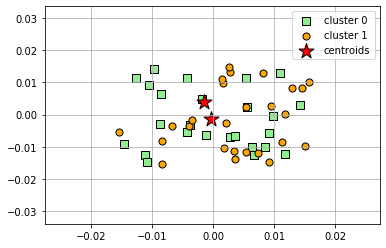

*************************** Start assigning cluster  Bruno Mars  -  Count On Me *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Count On Me *******************************************
["Count On Me, If you ever find yourself stuck in the middle of the sea,  \nI'll sail the world to find you  \nIf you ever find yourself lost in the dark and you can't see,  \nI'll be the light to guide you  \n  \nFind out what we're made of  \nWhen we are called to help our friends in need  \n  \nYou can count on me like one two three  \nI'll be there  \nAnd I know when I need it I can count on you like four three two  \nYou'll be there  \n'Cause that's what friends are supposed to do, oh yeah  \n  \nWhoa, whoa  \nOh, oh  \nYeah, yeah  \n  \nIf you tossin' and you're turnin' and you just can't fall asleep  \nI'll sing a song  \nBeside you  \nAnd if you ever forget how much you really mean to me  \nEveryday I will  \nRemind you  \n  \nOoh  \nF

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Dance In The Mirror *******************************************
#Test output for words in word2vec
danc
mirror
vers
wake
morn
jump
shower
rub
lotion
wrap
*************************** Start kmeans cluster  Bruno Mars  -  Dance In The Mirror *******************************************
[[ 1.1159454e-03 -1.5887667e-03  3.2228502e-03 -1.5655585e-03
   5.7654222e-04  4.5774230e-03 -1.5929341e-04 -1.1567883e-03
   6.2093779e-04 -3.5851107e-03  1.6893396e-03  1.7792319e-03
   2.5597315e-03 -2.5550595e-03  2.7333971e-03 -3.3994892e-04
   1.7996618e-03  1.6316159e-03  2.1948847e-03 -5.5700871e-03
  -4.2221360e-03 -6.5017666e-04  1.3793620e-03  1.0809279e-05
  -2.4964279e-04 -2.2842591e-04 -7.3297927e-04 -2.2562395e-03
  -2.1597280e-03 -5.9943611e-04 -3.5542276e-04 -1.8263516e-03]
 [-1.7889058e-03  1.8129640e-03 -2.7648048e-03  3.8401545e-03
   3.2080701e-03 -4.2986074e-03  6.0575209e-03 -1.9722519e-04
  -1.3474943e-04  2.2405242e-03 

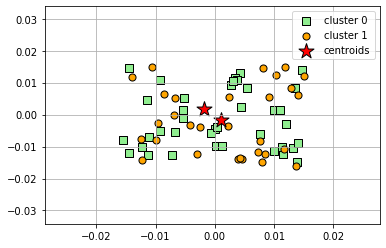

*************************** Start assigning cluster  Bruno Mars  -  Dance In The Mirror *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Dance In The Mirror *******************************************
["Dance In The Mirror, [Verse1]  \nShe wakes up in the morning, jumps in the shower  \nThen rubs on her lotion, while she's wrapped in a towel  \nAnd no music on, but she dance till perfection  \nI swear the bathrooms the club, the ways she's showing love to her reflection  \n  \n[Pre-Chorus:]  \nEvery morning I watch her from behind, but she don't know  \nI pretend that I'm asleep, but I don't miss her show  \n  \n[Chorus:]  \nMy favorite of the day,  \nIs when she dance in mirror  \nDance in the mirror  \nThere's nothing more I can say  \nJust watch her dance in the mirror  \nDance  \n  \nOeh she's so cute, cute, cute  \nDancin' in there nude, nude, nude  \nOooh  \n  \nMy favorite part of the day  \nIs when she dance in the m

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Freedom *******************************************
#Test output for words in word2vec
freedom
free
could
wrong
tell
leav
ooh
tempor
lost
mind
*************************** Start kmeans cluster  Bruno Mars  -  Freedom *******************************************
[[ 3.8294853e-03  3.6453896e-03  2.5577135e-03  1.0797129e-03
  -2.8056144e-03  4.7688568e-03 -9.7114523e-04  1.3497394e-03
  -4.6503014e-04 -1.7066953e-03  2.3301563e-03 -6.4288464e-04
   2.3822126e-05 -1.9091896e-03 -7.9255747e-03  9.8621473e-04
  -3.7009991e-04  2.7467608e-03 -1.2903502e-03  8.1337092e-04
   9.7075204e-04  1.9574733e-03 -2.5943390e-03  5.2238896e-04
  -6.0180359e-04 -2.2901534e-03  2.8365897e-04 -3.4323535e-03
   1.2319447e-03 -1.2766114e-03 -2.1938905e-03 -3.6022139e-03]
 [-1.9124972e-03 -5.0480552e-03 -2.1205400e-03 -1.8703853e-03
  -5.5925804e-04 -1.1539239e-03  1.4919535e-03 -1.2924062e-04
  -3.2613345e-05 -4.3632779e-03 -4.7820974e-03 -1.00857

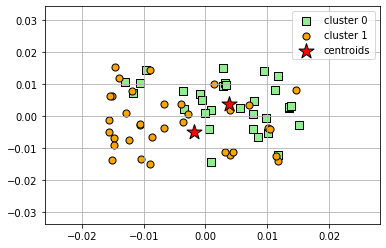

*************************** Start assigning cluster  Bruno Mars  -  Freedom *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Freedom *******************************************
["Freedom, Free free  \nFree free  \n  \nI could be wrong but are you telling me that you're leaving (ooh),  \nAnd so then you've temporally lost your mind,  \nAnd now you're checking your phone and you've noticed  \nIt's not ringing (waoh),  \nAnd the one that you wanted to call you pushed out your life,  \n  \nNow you're telling me it's me that you're needing,  \nFunny you didn't say that when you where leaving oh,  \nYou just walked out the door,  \n  \nI gave you all the love that you wanted from me,  \nNow tell me are you really free,  \nTell me are you really free,  \nCause you wanted freedom, (x2)  \n  \nYou said our love was a cell so I gave you the key to break out,  \nI would have done it before it saved us both some time,  \nBut isn't it ir

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Test output for words in word2vec
girl
wait
know
take
lifetim
thing
worth
hold
matter
far
*************************** Start kmeans cluster  Bruno Mars  -  Girl I Wait *******************************************
[[ 5.1141586e-03 -4.9244892e-04  4.0114233e-03  1.6532319e-03
   6.7138015e-03  3.4777196e-03  4.3719644e-03  4.4467333e-03
  -5.2662345e-04  2.5248362e-04  6.2144257e-04 -6.4954511e-03
   2.2839202e-04 -2.4531716e-03  7.3835207e-04  1.3069831e-03
  -1.1002239e-03 -2.8720242e-03  2.8112838e-03 -6.5377215e-05
  -4.1312752e-03 -2.0243318e-03  2.4080211e-03 -9.0765080e-04
   4.2674653e-03 -1.5474223e-03  2.3510421e-03 -3.4804116e-03
  -4.1511813e-03 -2.3034143e-03 -4.4899934e-04  1.1539843e-03]
 [ 1.8361717e-03 -2.2875462e-03 -4.3378728e-03  7.3190313e-06
  -4.1167280e-03 -3.3558230e-04 -5.0971480e-03 -2.4584611e-03
  -3.4943593e-04  1.5868536e-05 -2.4074633e-04  4.4702790e-03
   1.2469899e-03  2.4740463e-03 -1.3183894e-03 -3.5437695e-03
   4.0605166e-03  1.1761547e-03  2.0499108e

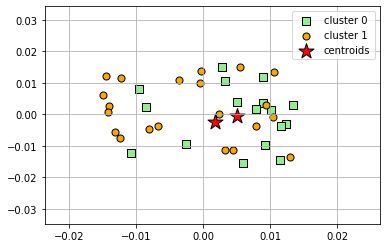

*************************** Start assigning cluster  Bruno Mars  -  Girl I Wait *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Girl I Wait *******************************************
["Girl I Wait, You know I wait for you  \nIf it takes a lifetime to do  \nGirl I will wait for you  \nYou're the only thing worth holding on to  \nNo matter how far  \nGirl I can't live without my heart  \nI hope you come home soon, soon  \nGirl I will wait for you  \nIf it takes a lifetime to do  \nGirl I wait  \nWait wait wait for you oh  \n  \nOur phone calls will have to do  \nWrite you letters just to prove  \nYou're the only thing on my mind  \nI'm going...  \nJust hold on I promise you  \nSoon you'll be here by my side  \nBut we can't stop time  \nSeems like the clock is running way too fast  \nAnd now I'm feeling lost  \nAnd I can't read your mind  \nBut you don't have to ask  \n  \nYou know I wait for you  \nIf it takes a lifetime to 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[-4.2111641e-03  2.4571843e-03 -1.8104145e-03  9.0066518e-04
   5.8814354e-04  4.2481935e-03 -3.0803848e-03  1.1313070e-03
   3.1489106e-03 -5.3878087e-03 -4.5503315e-05 -2.8025026e-03
  -3.1897346e-03  2.9193731e-03  9.3894853e-04 -1.2277330e-03
  -3.5718766e-03  2.3254128e-03 -7.3900307e-04 -3.5866559e-04
   1.5790261e-03  1.4043231e-03  4.8441841e-05  2.0975296e-03
   4.9327069e-04  1.1675603e-03  4.2244862e-04  5.4321024e-03
  -1.4632428e-03 -3.0676974e-03  1.0809031e-03 -1.8703343e-03]
 [ 3.3352459e-03 -2.5786210e-03  8.4106894e-03  1.3489381e-04
   3.0469452e-04 -3.8765771e-03 -6.3386548e-04 -1.6116075e-03
  -5.8140070e-03  6.5619689e-03  9.3737361e-04  4.8836116e-03
   6.4360942e-03 -3.9792480e-03  3.3939744e-03  7.2147427e-03
   4.7751539e-03  3.8966641e-04  7.4487209e-04 -3.2612407e-03
   2.8917557e-03 -9.1767701e-04 -8.1407616e-04  2.0457187e-03
  -2.7881856e-03 -1.7475154e-03  3.9060784e-03 -8.0722407e-04
   2.2904340e-03  3.4919120e-03 -6.6112832e-04  4.9148654e-03]]


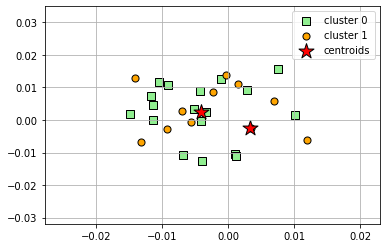

*************************** Start assigning cluster  Bruno Mars  -  Gold *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Gold *******************************************
["Gold, Chorus:  \nThere's no light in this room,  \nIt's so bright, we got you,  \nYou shine like, oh, oh, oh, oh,  \nYou are bright, cause I see,  \nAll the guys...  \nYou shine like gold oh, oh, oh, oh,  \n  \nAnd every time you come around,  \nCupid ain't got shit on me.", "I got your...  \nSee Cupid ain't got shit on me.", "See all these niggers, we're popping at bullshit,  \nBut I begin it like a preacher in a...", "It ain't the fuck cause I...", 'But every time they fail, she run right back to mister...', "Chorus:  \nThere's no light in this room,  \nIt's so bright, we got you for shining, oh, oh, oh, oh,  \nYou are bright, cause I see,  \nAll the guys...  \nYou shine like gold oh, oh, oh, oh"]




{'Gold': {'gold': 2, ',': 16, 'choru': 1, ':': 1, "'

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[ 1.4946535e-03 -2.1710503e-03 -1.6593335e-03  2.6072427e-03
   3.3819829e-03  8.5610838e-05  1.3979657e-04  1.2446586e-03
  -1.8352792e-03 -8.0394780e-04  2.1738291e-04 -3.2874534e-04
  -1.7476452e-03  6.1828189e-04 -9.9273096e-04 -8.0542802e-04
  -1.6819993e-03  1.7676692e-03  1.5333287e-03 -3.4073163e-03
  -3.7248997e-04  1.6753981e-03  1.7997787e-03  2.5226981e-03
  -2.2298112e-04 -7.9543423e-04 -4.1764616e-03 -1.1566392e-03
  -2.1704813e-03  1.5527407e-03  1.5517195e-03  2.1475493e-03]
 [-5.0097698e-04  4.7240593e-03  3.6442396e-03 -3.1548098e-03
  -7.5805257e-04  1.2155718e-03  3.3723682e-04  1.1738925e-03
  -4.2600762e-03 -4.5924028e-04  2.8999723e-03  4.2978977e-03
   1.3127176e-03 -1.9304400e-03 -2.9767379e-03 -3.8463767e-03
   1.6679491e-03 -2.7101855e-03  1.6523193e-04  2.3869795e-03
   1.7880142e-04  1.2541865e-04 -8.8400915e-03 -3.3648708e-03
   1.6088061e-03  2.4748589e-03  5.5926819e-03  2.4993103e-03
   8.5097307e-04 -4.2937617e-03 -4.3941028e-03 -3.4993964e-03]]


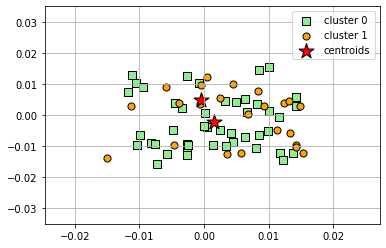

*************************** Start assigning cluster  Bruno Mars  -  Gorilla *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Gorilla *******************************************
["Gorilla, Oh I got a bottle full of liquor with a cocaine  \nKicker and I'm feeling like I'm thirty feet tall  \nSo lay it down, lay it down  \nYou got your legs up in the sky with the devil in your eyes  \nLet me hear you say you want it all  \nSay it now, say it now  \n  \nLook what you doing, look what you done  \nBut in this jungle you can't run  \n'Cause what I got for you  \nI promise is a killer, you'll be banging on my chest  \nBang bang, gorilla  \n  \nOoh ooh ooh yeah, you and me baby making love like gorillas  \nOoh ooh ooh yeah, you and me baby making love like gorillas  \n  \nYeah I got a fistful of your hair  \nBut you don't look like you're scared  \nYou're just smiling tell me daddy it's yours  \n'Cause you know how I like it use a di

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Grenade *******************************************
#Test output for words in word2vec
grenad
easi
come
go
live
oh
take
never
give
known
*************************** Start kmeans cluster  Bruno Mars  -  Grenade *******************************************
[[ 3.5205828e-03 -1.4389160e-03  2.7978513e-03 -1.5375941e-03
  -3.8706695e-04  1.1817937e-03  2.0927279e-03 -4.0932060e-03
  -2.6739782e-03  7.3892856e-04 -2.1544260e-03 -1.8463129e-03
  -1.1131449e-03 -2.0888720e-03 -1.6610174e-03  7.1425980e-05
   2.6174150e-03 -8.3421852e-04 -2.2337404e-03  1.2282090e-03
  -2.8861864e-03  2.1109898e-03 -2.3165611e-03 -2.1516178e-03
   3.7559695e-04 -2.4187908e-04 -1.4837957e-03 -4.5028250e-03
  -3.6079213e-03  1.1418621e-03 -3.8579423e-03 -4.6044444e-03]
 [ 3.1619298e-04  3.6308183e-03  7.6838501e-04  6.6756789e-04
   1.5447050e-03 -4.0865466e-03 -3.4336539e-03  6.1691348e-03
  -1.2158540e-03 -2.4223814e-04  9.1117067e-04  3.7413365e-03

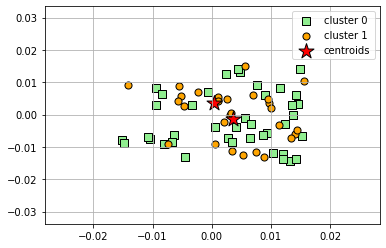

*************************** Start assigning cluster  Bruno Mars  -  Grenade *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Grenade *******************************************
["Grenade, Easy come, easy go, that's just how you live oh  \nTake, take, take it all, but you never give  \nShould have known you was trouble from the first kiss  \nHad your eyes wide open,  \nWhy were they open?", "Gave you all I had and you tossed it in the trash  \nYou tossed it in the trash, you did  \nTo give me all your love is all I ever asked 'cause  \nWhat you don't understand is I'd catch a grenade for ya (yeah, yeah)  \nThrow my head on a blade for ya (yeah, yeah)  \nI'd jump in front of a train for ya (yeah, yeah)  \nYou know I'd do anything for ya (yeah, yeah)  \n  \nOh oh, I would go through all this pain  \nTake a bullet straight through my brain  \nYes, I would die for ya baby  \nBut you won't do the same  \n  \nNo, no, no, no  \nBlac

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[ 4.2739785e-03 -4.2363504e-04  7.3835277e-04  1.4008842e-03
  -7.2386046e-04  1.5195335e-03  3.1457155e-04  4.1675882e-04
   2.7303630e-04 -4.0842178e-03  6.8500277e-04 -1.1384735e-03
  -3.0270624e-03  2.9605252e-03 -2.5261198e-03 -2.1298914e-03
  -2.8667494e-03  6.0759224e-03 -8.8648655e-04 -1.7272235e-03
  -9.3715847e-04  1.7266357e-04 -1.1322983e-03  1.5620545e-03
   8.0038793e-05 -5.1335152e-03 -3.7154910e-04  4.2123999e-03
  -1.6715251e-03  2.4026441e-03  2.4486897e-03 -3.3718147e-03]
 [ 5.9436029e-04  5.3610670e-04 -1.6196686e-03  2.6468511e-03
  -2.8111511e-03 -3.0583171e-03  4.7253883e-03  4.6933452e-03
   1.6428572e-03  5.0432119e-03  1.4665745e-03 -9.0013974e-04
   7.0243962e-03 -2.7126854e-03 -6.6629937e-04 -3.5965734e-03
   4.2491504e-03 -3.5010881e-03  2.4738552e-03  1.7227388e-03
  -1.1669594e-03  8.8296947e-04 -6.9286325e-05 -1.3229973e-03
  -3.4003165e-03  3.2571426e-03 -8.2784041e-05 -3.7288570e-03
   2.4242043e-03 -2.9886882e-03 -4.9174684e-03 -2.7469476e-04]]


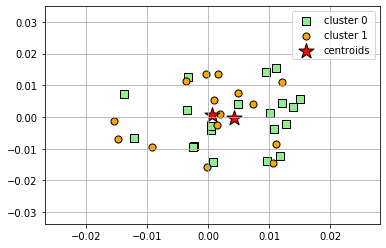

*************************** Start assigning cluster  Bruno Mars  -  Her World Goes On *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Her World Goes On *******************************************
["Her World Goes On, I'm without her somewhere far away  \nI keep thinking about her but I know I can't stay  \nShe haunts me like a nightmare her image is everywhere  \nShe doesn't leave me alone  \nI can't escape her or erase her  \nWhen I know she's not coming home  \n  \nI can't understand where I went wrong  \nI can't understand where her love has gone  \nI don't know where I belong  \nMy world is over  \nWhen life goes on (her world goes on) and on and on  \n(Her world goes on)  \nWhen life goes on (her world goes on) and on and on  \n(My world is gone)  \n  \nAm I crazy or just human  \nIs this what heartbreak is  \nWhat should I be doing  \nIt feels like I got seconds to live  \nShe haunts me like a nightmare her image is e

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[-1.1316484e-03 -2.1640440e-03 -6.8130656e-03  1.5643814e-03
  -6.0795611e-03  3.9308444e-03 -3.0550726e-03  4.6085624e-04
  -1.7128387e-03 -1.3531226e-04 -3.2505300e-04  3.1315112e-03
   4.0670405e-03  1.0306125e-03 -9.9573133e-04 -1.5911217e-03
   4.3035559e-03  1.8798071e-03  2.0008916e-03 -2.3348546e-03
   8.6612999e-04  1.7001695e-03 -1.9073103e-03  7.1099009e-03
   4.7539652e-04 -7.5362035e-04 -3.8122330e-03  1.0882480e-03
  -1.8363257e-03 -1.9975000e-03 -1.7555486e-04  4.8383395e-03]
 [-1.1568933e-03  5.5051659e-04  8.1754895e-03 -1.1972291e-03
  -1.7834827e-06  1.1678447e-03  1.9904482e-03 -2.2281536e-03
  -6.4220959e-03 -1.4204845e-03 -2.7346797e-03 -9.7884773e-04
  -3.7029958e-03 -4.3443902e-03  3.5038525e-03  2.8603578e-03
   2.8640863e-03 -1.8396153e-03  2.4782331e-04  1.5949463e-03
  -1.3644608e-03  1.9503030e-03 -3.7789659e-03 -3.0572205e-03
  -2.2367185e-03  7.8800548e-04  8.0198571e-03 -1.1148446e-03
   1.5708436e-03 -1.5154588e-03 -3.1832315e-08 -7.8461524e-03]]


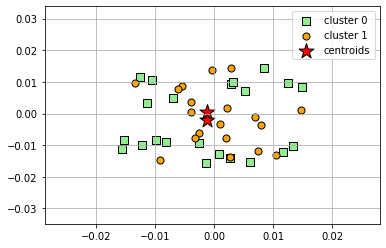

*************************** Start assigning cluster  Bruno Mars  -  If I Knew *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  If I Knew *******************************************
["If I Knew, Oh, oh I, I was a city boy  \nRiding to danger's where I'd always run above and is hurt  \nI wouldn't have done  \nAll the things that I've done  \nIf I knew one day you would come  \n  \nNow, baby, now, baby, now, baby  \nOh, oh, oh, I, I know it breaks your heart  \nTo picture the only one you wanna love  \nIn someone else's arms, but I wouldn't have done  \n  \nAll the things that I have done  \nIf I knew one day you would come  \n  \nNow, baby, now, baby, now, baby  \nOh, baby, please, let's leave the past behind us  \n  \nSo that we can go where love will find us  \nYeah, will find us  \n  \nI know once girls would leave me  \nBut I know that you believe me  \n  \nBaby, I, I wish we were seventeen  \nSo I could give you all the i

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[-1.0390389e-03  3.6288202e-03 -3.6572474e-03 -2.6716001e-04
  -5.3500605e-04  1.7365598e-03 -2.9158129e-03 -4.7426177e-03
  -5.6074122e-03 -1.0708574e-03  2.6116807e-03  9.5014926e-05
   1.1156406e-04 -1.0900039e-03 -6.0873700e-04  4.0045069e-03
   3.4971198e-03  5.6165308e-03  2.1293818e-05 -1.9654820e-03
  -4.0567024e-03  2.2795100e-03  2.4688561e-03  5.1097851e-04
  -2.0121192e-03  1.8804442e-03  3.1987557e-03 -1.7156890e-03
  -5.1044044e-04 -1.6653572e-03 -4.1438811e-03 -4.3130149e-03]
 [ 2.6839019e-03 -6.8743778e-03  1.2445984e-03  3.8536368e-03
  -4.2115040e-03  1.2605473e-03  6.0822563e-03  1.5452085e-04
   1.6703696e-03  3.3384138e-03 -3.4849346e-04 -5.4641040e-03
   2.4009170e-03  1.4640926e-04  3.8086833e-03 -2.4635973e-03
   6.6827354e-04 -2.5490155e-03 -1.5387397e-03 -3.9142636e-03
   2.0193770e-03 -6.9578644e-05  1.5311094e-04 -3.7191208e-03
   5.0826417e-03 -1.9853872e-03  1.4507112e-03  3.7023146e-04
  -1.0595636e-03  2.7933349e-03 -1.9804002e-03 -9.7550149e-04]]


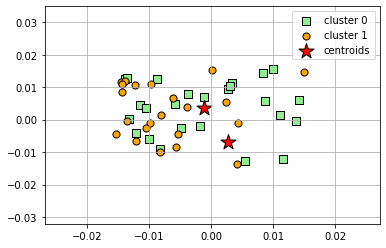

*************************** Start assigning cluster  Bruno Mars  -  Innocent *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Innocent *******************************************
["Innocent, Don't say it's over  \nCoz your girl in you ear  \nAll the time  \nIt's paranoia  \nThey've been playing  \nTricks on you mind  \nDo they control ya  \nGirl you know me better than I  \nOh let me show ya  \nOh let me show ya  \nNo I would never do that to you  \nGirl look in my eye  \nYou know me won't lie  \nAnd I would do all I can to prove  \nGirl I will prove it  \nIf I'm guilty I would pay  \nFor the crime you said I made  \nBut I swear it wasn't me  \nNo I didn't do it  \nIf I'm giulty I would pay  \nGirl I know I made mistakes  \nBut before you sentence me  \nNo I didn't do it  \nI'm pleading innocent innocent  \nYou know me wouldn't do that to you  \nGirl, I'm pleading innocent innocent  \n  \nI'm innocent  \nThey say I'm creepy 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Test output for words in word2vec
way
oh
eye
make
star
look
like
shine
hair
fall
*************************** Start kmeans cluster  Bruno Mars  -  Just The Way You Are *******************************************
[[ 3.0437771e-03 -1.7609887e-03  7.0169503e-03 -1.7499155e-04
   1.0385904e-03  1.3194113e-03  6.0305384e-04  2.2810376e-03
  -5.2757496e-03 -1.5034971e-03 -3.2728660e-04  3.5692228e-04
  -1.0899573e-03 -6.2741530e-03 -1.6926500e-03  6.4211180e-03
  -1.8525745e-03 -2.5098966e-03 -1.6550068e-05  1.7957092e-03
   6.9902482e-04  8.0116307e-03 -2.0426963e-03 -2.1474552e-03
  -1.0309371e-04  3.0782060e-03  5.4968153e-03  8.9337392e-04
  -3.6945203e-03  2.5983073e-04  3.8448407e-03 -8.6208445e-04]
 [ 2.0424325e-03 -3.7977844e-04 -4.3170094e-03  1.8505466e-03
   4.4502440e-04 -3.3208495e-03  8.7378453e-04  2.2489456e-03
   1.4230366e-03 -2.6566046e-03  1.1264938e-03  2.6520498e-03
  -3.1922996e-04  2.6913823e-03 -2.3945346e-03 -3.2555100e-03
   3.6455328e-03  3.8876571e-03 -1.8990466e

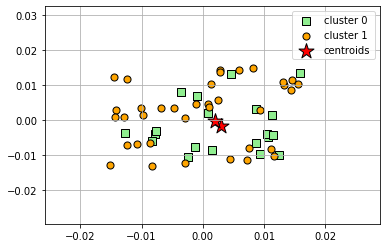

*************************** Start assigning cluster  Bruno Mars  -  Just The Way You Are *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Just The Way You Are *******************************************
["Just The Way You Are, Oh her eyes, her eyes  \nMake the stars look like they're not shining  \nHer hair, her hair  \nFalls perfectly without her trying  \n  \nShe's so beautiful  \nAnd I tell her every day  \n  \nYeah,  \nI know, I know  \nWhen I compliment her  \nShe wont believe me  \nIt's so, it's so  \nSad to think she don't see what I see  \nBut every time she asks me do I look okay  \nI say  \n  \nWhen I see your face (face)  \nThere's not a thing that I would change  \n'Cause girl you're amazing (amazing)  \nJust the way you are  \nAnd when you smile (smile)  \nThe whole world stops and stares for awhile  \n'Cause girl you're amazing (amazing)  \nJust the way you are  \nYeah  \n  \nHer lips, her lips  \nI could kiss 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Killa On Tha Run *******************************************
#Test output for words in word2vec
killa
tha
run
recogn
reflect
see
product
decept
gave
without
*************************** Start kmeans cluster  Bruno Mars  -  Killa On Tha Run *******************************************
[[-1.1262886e-03 -4.3094577e-03  1.9628636e-03 -6.0161581e-04
  -1.3103461e-03  5.5838947e-04 -7.8445370e-04 -7.7204924e-04
  -2.8336316e-04 -2.7455310e-03 -4.6037897e-03  1.3839854e-03
  -5.0577917e-05  6.4066733e-04 -1.0411253e-03  2.9220711e-05
   3.1068618e-04 -2.3562468e-03  5.8581453e-04  2.8520622e-03
  -2.1313021e-03  3.1199781e-03  7.9473469e-04 -1.5619594e-03
  -2.1874821e-03 -7.7646156e-04  8.0098899e-04 -2.5492711e-03
  -5.9060957e-03 -4.1199999e-04 -7.1151386e-04 -6.5649729e-03]
 [ 1.8958788e-03 -2.2407877e-04 -4.9135862e-03  6.0227036e-04
  -3.6678923e-04 -5.1132520e-03  2.9439440e-03  1.2548025e-03
  -6.5632071e-04 -4.3164636e-04 

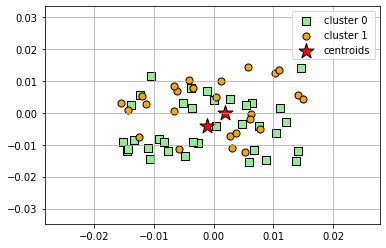

*************************** Start assigning cluster  Bruno Mars  -  Killa On Tha Run *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Killa On Tha Run *******************************************
["Killa On Tha Run, I don't recognize my reflection  \nAll I see is a product of your deception  \nGave you all of me without question  \nBut you had to take advantage of a blessing  \nI warned you, I told you it would end this way  \nIf you kept on playing all those childish games  \nBut just like every other man you're all the same  \nRevenge is sweet I love the taste it's giving me  \n  \nI'm a killer on the run  \nYou broke my heart and now you're staring at my gun  \nClick clack now watch me pull this trigger just for fun  \nWas once a good girl now a killer on the run  \nK-k-killer, k-k-killer, k-k-killer  \nK-k-killer on the run  \nKiller on the run  \nK-k-killer on the run  \n  \nWipe those tears from your eyes it's too late 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Lights *******************************************
#Test output for words in word2vec
light
dim
sweet
darl
caus
tonight
way
turn
old
victrola
*************************** Start kmeans cluster  Bruno Mars  -  Lights *******************************************
[[-0.00219078 -0.00173939 -0.00128088 -0.00069471  0.00021601 -0.00400725
  -0.00046387  0.00170221 -0.00064082 -0.00280655  0.00326717 -0.0005164
   0.00117216 -0.00354694 -0.00263988 -0.00469124 -0.00072419  0.0013291
  -0.0029375  -0.00020489 -0.00081485  0.00637545 -0.00186812  0.00584029
   0.00352765  0.00115073 -0.00196023 -0.00375273  0.00599322 -0.00219659
   0.0028384   0.00118985]
 [-0.00034261 -0.00110663  0.00156351  0.00077391 -0.00366684 -0.00120493
   0.00174627  0.00242419 -0.00171863 -0.00062658 -0.00086017 -0.00028976
   0.00329637  0.00322627  0.00299866 -0.00068781  0.00359093  0.00064026
   0.00439441  0.00156393 -0.00133114 -0.0031784   0.00123458

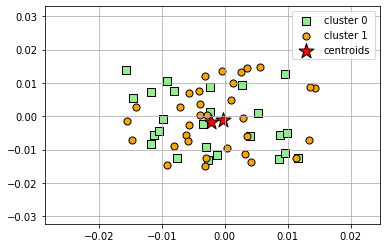

*************************** Start assigning cluster  Bruno Mars  -  Lights *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Lights *******************************************
["Lights, Dim all the lights sweet darling  \nCause tonight it's all the way  \nTurn up the old Victrola  \nGonna dance the night away  \n  \nLove just don't come easy  \nNo it seldom does  \nWhen you find the perfect love  \nLet it fill you up  \n  \nDim all the lights sweet darling  \nCause tonight it's all the way, hey baby  \nTurn up the old Victrola  \nGonna dance the night away  \n  \nLove just don't come easy  \nNo it seldom does  \nWhen you find the perfect love  \nLet it fill you up  \n  \nDim all the light sweet honey  \nCause tonight it's you and me  \nNo need to worry darlin'  \nCause it's for eternity  \n  \nLove don't come easy  \nThis you know I understand  \nI want to be your woman  \nIf you'll be my man  \nLet yourself go freely and I'l

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Lost *******************************************
#Test output for words in word2vec
lost
fuck
crazi
get
hard
wait
tri
make
see
realli
*************************** Start kmeans cluster  Bruno Mars  -  Lost *******************************************
[[ 1.03720231e-03 -1.70495606e-03  2.14018393e-03 -3.70447943e-03
   3.01187322e-03  5.96457347e-03  1.11307134e-04  2.60563334e-04
  -2.01978721e-03 -5.40781533e-03 -1.20955100e-03  2.81523075e-03
  -3.13241006e-04 -4.86267824e-03 -2.13775807e-03  1.96609227e-03
   1.44683861e-03  5.29480912e-03  1.16875023e-03 -2.13845726e-03
  -4.90111997e-04  1.95716158e-04  2.54459935e-03 -1.38802861e-03
   9.86034865e-04  9.36129014e-04  1.41993409e-03 -7.26028229e-05
  -2.54438422e-03  1.02994114e-03  3.90454335e-03 -1.60282804e-03]
 [-4.46523016e-04  1.73238281e-03  4.62438678e-04  2.02061376e-03
  -2.49307672e-03 -6.09369762e-03  3.25631117e-03 -8.60065746e-04
   2.99837114e-03  5.840940

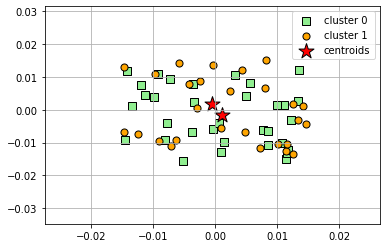

*************************** Start assigning cluster  Bruno Mars  -  Lost *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Lost *******************************************
['Lost, What are you fucking crazy?', "It's getting hard to wait,  \nI'm trying to make her see,  \nThat she don't really knows  \nThat I'm trying to find a way,  \nAnd tell her every day, that she just goes along  \nSo I...", "I don't wanna be,  \nThe only one that knows  \nThat somebody could come along and just  \nSay the love for me,  \nI'm standing shaking ground,  \nAnd I'm been thinking that I'm gonna lose it,  \n  \nChorus:  \nCause I'm losing my head,  \nI'm losing my mind,  \nI'm losing control of myself this time.", "She's got me losing my head,  \nI'm losing my mind,  \nI'm losing my way,  \nBut I think she feels I'm already caught.", 'Are you talking to me?', "I'm already caught.", "I wish that I could see,  \nBut it's making you  \nFeel this s

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Test output for words in word2vec
love
hollywood
want
make
think
know
tell
true
see
movi
*************************** Start kmeans cluster  Bruno Mars  -  Love *******************************************
[[ 0.00406758 -0.00133873 -0.0021158   0.00041523 -0.00487561 -0.00158243
  -0.00140631  0.00176675 -0.00019156  0.00462806  0.00170758 -0.00256142
   0.00416655 -0.00209926  0.0005489  -0.00606623  0.00147435 -0.0001614
  -0.00192769  0.00012272 -0.00042115  0.0014815  -0.00282607  0.00113167
  -0.00028006  0.00030262 -0.0022825  -0.00242557  0.00095295 -0.0035838
  -0.0013354   0.00196229]
 [-0.00164473  0.0023369   0.00073391 -0.00460441  0.00402218  0.00517461
   0.00348938 -0.00070206 -0.00135324 -0.00418186  0.00401598  0.0010516
  -0.00444971  0.00061689 -0.00146344  0.00299486 -0.00091421  0.00058653
   0.00035123  0.0021185   0.00101737 -0.00022781  0.00247657  0.00097484
  -0.00074218  0.00181428  0.00147003  0.00176388  0.00088593  0.00214832
   0.00197867  0.00011707]]


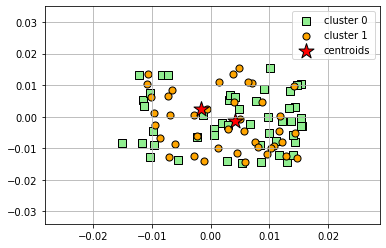

*************************** Start assigning cluster  Bruno Mars  -  Love *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Love *******************************************
['Love, Now Hollywood wants to make you think they know what love is.', "But I'm a tell\nyou what true love is.", 'Love is not what you see in the movies.', "It's not the\necstasy it's not what you see in that scene you know what I mean?", "I'm telling\nyou right now true love is sacrifice.", 'Love is thinking about others before you\nthink about yourself love is selfless not selfish.', 'Love is God and God is\nlove.', "Love is when you lay down your life for another whether for your brother\nyour mother your father or your sister it's even laying down your life for\nyour enemies that's unthinkable but think about that.", 'Love is true.', 'Think.', "I'll put you in front of me  \nSo everybody can see  \nMy love this is my love  \n  \nI know that I'll be alr

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Test output for words in word2vec
madli
love
see
everyday
tri
find
differ
way
build
kind
*************************** Start kmeans cluster  Bruno Mars  -  Madly In Love With You *******************************************
[[-1.6743102e-03  1.8890731e-03  2.7990520e-03  1.7791255e-03
  -3.4700991e-03 -3.5871795e-05  2.0937622e-03  2.9266468e-04
  -4.5976480e-03 -2.2669171e-04  5.6393899e-04 -5.4246364e-03
   1.2311265e-03 -1.5053421e-03  1.1760467e-03 -3.6616838e-03
   4.8541771e-03  2.2878830e-04  2.1954626e-03  1.4115823e-05
  -1.3587240e-03 -4.5821546e-03  5.3919241e-04 -2.2265967e-04
   3.7482008e-03 -5.1543233e-03  3.1980770e-03  2.9425619e-03
  -5.4694444e-04 -6.3884910e-03  5.2797114e-03 -5.0163493e-03]
 [ 2.6653538e-04 -2.1540145e-03 -3.1051988e-04 -2.3602585e-03
   2.1651138e-03  1.6071770e-04  1.8027897e-03  6.0012535e-04
   2.1811570e-03 -9.0249945e-05  3.1153866e-04  3.5103490e-03
   4.2718428e-05 -1.5580439e-04 -1.6498470e-03  1.8245284e-04
   2.7743867e-04 -4.1059134e-04 -

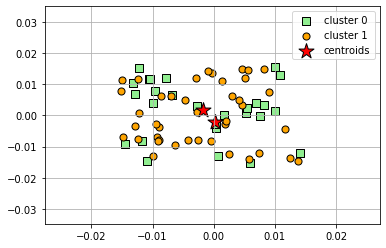

*************************** Start assigning cluster  Bruno Mars  -  Madly In Love With You *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Madly In Love With You *******************************************
["Madly In Love With You, Madly In Love With You  \n  \nSee you down there everyday  \nTrying to find a different way  \nTo build some kind of latter to the sky  \n  \nTrying to find some way to see  \nSecrets of eternity, and they don't come all at once  \nAnd you don't know why  \n  \nWell how do you think it feels to hear you screaming out my name  \nWhile all the while I'm trying to open up your heart  \nSee you when you cry yourself to sleep  \nIt's tearing me apart  \n  \nI know you wish you could see me  \nThat's the way it has to be  \nSomeday you'll understand,  \nDon't you lose your faith in me  \n  \nI know you wish you could hear me  \nSometimes it's so hard to do  \nBut every morning sunrise it says  \nI'm ma

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Test output for words in word2vec
mama
worst
nightmar
love
got
trippin
flippin
heart
fli
high
*************************** Start kmeans cluster  Bruno Mars  -  Mama's Worst Nightmare *******************************************
[[ 5.7348097e-03  4.0695476e-04  2.1556143e-03 -1.9943216e-03
   4.3080468e-03  3.3771219e-03 -1.5615963e-03 -3.8009537e-03
   9.8781195e-05 -5.0999210e-03 -2.0032788e-03 -4.3437991e-04
   5.4338382e-04 -1.4782699e-03 -1.4914046e-03  5.1246386e-04
   8.6986460e-05  3.9959443e-03 -2.2519147e-03  2.5338999e-03
   3.6610605e-03  4.1326042e-03  1.0430912e-03  2.1700144e-03
   2.7373279e-03 -2.7825511e-03  2.2027525e-04 -1.5086401e-03
  -9.0654759e-04  9.5805561e-04  1.2800837e-03 -3.2671557e-03]
 [-6.3737649e-03 -6.7481148e-04 -3.6028312e-03  2.9414839e-03
  -2.6434220e-03 -3.0441806e-03  5.6799091e-03  1.8545300e-03
  -3.0116446e-03  2.1992049e-03  2.6693675e-03 -6.7682035e-05
   2.1657172e-04  1.6265328e-03  5.9165750e-03 -9.7775180e-04
   3.5231230e-03  1.1067521e

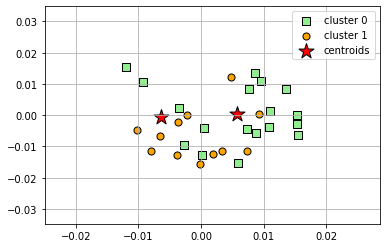

*************************** Start assigning cluster  Bruno Mars  -  Mama's Worst Nightmare *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Mama's Worst Nightmare *******************************************
["Mama's Worst Nightmare, Your love got me trippin'  \nBut now that you're flippin'  \nWith my heart,  \nWe were flying high but we're dipping  \nIn my heart,  \nOhh I am a fool for you,  \nI go running home  \nEverytime, you walk out on me  \nI thought we were going strong but now it's easy to see my mama was right\nyou're my  \nMama's worst nightmare no doubt about that  \nYou are my mama's worst nightmare  \nNo doubt that you are  \nYour love got me running  \nBut now that you're cunning  \nLittle plans  \nOhh have got me flipping  \nAnd dipping  \nYou're cunning whilst  \nI'm running  \nYou're my, you're my, you're myyy  \nMy mama's worst nightmare no  \nMama's worst nightmare no doubt about that  \nYou are my mama's 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[-6.3071487e-04 -2.3565860e-03 -4.4978578e-03  3.6093853e-03
  -2.0968881e-03 -3.2858942e-03 -1.9316928e-03  4.7065690e-03
  -9.3008933e-04 -3.9082114e-03  1.6394969e-03  7.2328595e-04
  -6.9106120e-04  1.2885642e-03 -5.5114634e-04 -5.6516584e-03
  -2.5395388e-04  1.0961434e-05  4.4075064e-03 -7.3249908e-03
  -1.3976904e-03 -3.8572210e-03  1.2726914e-03  3.3385521e-03
  -1.1383130e-03 -3.8821874e-03  2.7600001e-04  5.7156980e-03
  -1.5745547e-03 -7.3988677e-04 -1.0584232e-03 -2.5020903e-03]
 [ 1.4305122e-03  4.0483470e-03  2.6417393e-03 -7.0245210e-03
   2.2124322e-03 -2.0889468e-03 -4.6049003e-03 -2.6320517e-03
  -1.8301094e-03  2.4908723e-04 -1.1808410e-03  2.5458352e-03
   8.9302385e-04 -6.3167857e-03  7.3385373e-04 -1.2638932e-04
  -8.1313867e-04  1.9927337e-03 -7.7629602e-04 -2.2082359e-03
  -1.7071880e-03  3.9711241e-03 -1.4923579e-03 -1.5414350e-03
  -4.9250474e-04 -1.7698365e-04  2.9981937e-03 -6.1300355e-03
  -1.4590647e-04  5.6078093e-04 -3.0204996e-03 -1.0800287e-03]]


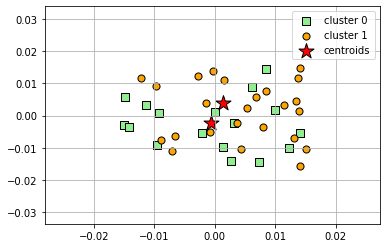

*************************** Start assigning cluster  Bruno Mars  -  Money Makes Her Smile *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Money Makes Her Smile *******************************************
["Money Makes Her Smile, Are you getting back, coming to the stage is a girl who's new in town  \nShe goes by the name where your stacks at  \nThis pretty little thing I swear wont let you down  \nWatch it drop it like... Hey  \n  \nIt's not complicated, so this wont take a while  \nYou see music make her dance, and money money money make her smile  \nMoney money money make her smile  \nMoney money money make her smile  \n  \nShe's a super freak  \nYou wouldn't know it if you saw her outside these velvet walls  \nNo she don't go where preachers preach  \nShe only go to the church when dollars foam  \nWatch it drop it like... Hey  \n  \nIt's not complicated, so this wont take a while  \nYou see music make her dance, and mone

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[ 1.13348442e-03  3.07608116e-03 -7.42065895e-04 -1.31803681e-03
   1.21274428e-03  3.49510461e-04  5.00579458e-03 -3.25442548e-03
  -2.48572370e-03 -5.38694672e-04  2.98095262e-03 -4.97807690e-04
   4.19798365e-04 -3.81335150e-04 -6.54964650e-04 -4.73365700e-03
   5.62348403e-03 -2.06362572e-03  3.75651405e-04  6.41847844e-04
   3.41541832e-03  2.64372025e-03  1.68758561e-04 -1.76360016e-04
   1.47945678e-03  4.62306384e-03  2.71933782e-03 -1.12301204e-04
   5.54153812e-04  2.95357406e-03 -2.64711957e-03 -2.02046311e-03]
 [ 1.42765907e-03 -5.80066699e-04  1.06215407e-03 -2.68492661e-03
  -1.21724326e-03  9.55988187e-04 -6.32684026e-03  2.22848612e-03
  -4.08994383e-04 -2.57883826e-03 -3.31874727e-03  1.61429096e-04
   1.70475384e-03 -3.98180302e-04 -1.50167244e-03  2.65384978e-03
  -5.52175799e-04  2.23158160e-03 -1.92771875e-03 -3.40547506e-03
  -3.67171830e-03 -3.66687658e-04 -4.70363477e-04  2.80660950e-03
  -1.82676769e-03 -3.18383519e-03 -2.02099676e-03 -1.06155197e-03
  -1.9645

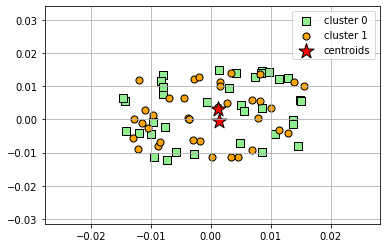

*************************** Start assigning cluster  Bruno Mars  -  Moonshine *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Moonshine *******************************************
["Moonshine, Hello  \nYou know you look even better than the way you did now before  \nAnd the moment that you kissed my lips you know I started to feel wonderful  \nIt's something incredible, there's sex in your chemicals  \nOh, let's go  \nYou're the best way I know to escape the extraordinary  \nThis world ain't for you, and I know for damn sure this world ain't for me  \nLift off and say goodbye  \nJust let your fire set me free  \n  \nMoonshine, take us to the stars tonight  \nTake us to that special place  \nThat place we went the last time, the last time  \n  \nI know, I was with you last night but it feels like it's been so long  \nAnd everybody that's around they know that I'm not myself when you gone  \nIt's good to see you again, good t

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Natalie *******************************************
#Test output for words in word2vec
natali
oh
never
done
wanna
long
turn
dusti
road
pretend
*************************** Start kmeans cluster  Bruno Mars  -  Natalie *******************************************
[[-1.9233294e-03 -2.9977409e-03 -2.1200674e-03 -1.1245164e-03
  -4.3698237e-03 -1.6245996e-03  1.0906982e-03 -2.7652821e-03
   8.1939239e-04  8.5089507e-04 -2.3353333e-03  3.5696845e-03
   4.7534700e-03  1.2312045e-03  3.0633723e-03  1.3779645e-03
   2.6240973e-03 -6.1750424e-04  2.1038153e-03 -1.7010253e-03
   2.8468762e-03  1.5597600e-03 -7.4878160e-04  4.6872941e-04
  -4.3908530e-04  2.4046239e-03  3.4440586e-03  3.6443013e-03
   5.3613842e-04 -2.8157779e-03 -5.4179779e-03  3.7326629e-04]
 [ 2.8703695e-03  2.5766427e-03  3.0959472e-03 -8.0837967e-04
   5.1044808e-03  3.6678165e-03 -8.5962180e-04  1.8420859e-03
  -3.6144820e-03 -1.2931899e-03  3.2567603e-03 -2.98359

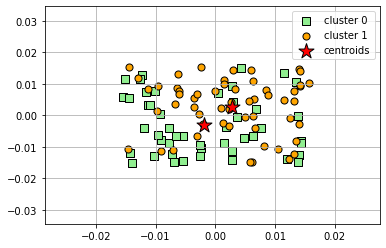

*************************** Start assigning cluster  Bruno Mars  -  Natalie *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Natalie *******************************************
["Natalie, Oh I never done this before  \nNever wanna do this again  \nLong turn on a dusty road  \nI did it to myself so I can't pretend  \nWell I learned just a little too late  \nGood God I must've been blind  \n'Cause she got me for everything, everything, everything, alright  \nLike my daddy I'm a gambling man  \nNever been afraid to roll the dice  \nBut when I put my bet on her  \nLittle miss snake eyes ruined my life  \nShe better sleep with one eye open  \nBetter make sure to lock her door  \n'Cause once I get my hands on her, I'ma oh  \n  \nNatalie, she ran away with all my money  \nAnd she did it for fun  \nNatalie, she's probably out there thinking it's funny  \nTelling everyone  \nWell I'm digging a ditch for this gold-digging bitch  \nWat

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 0.0
way 0.0
go 0.0
payback 0.0
beg 0.0
laugh 0.0
sit 0.0
cri 0.0
night 0.0
spend 0.0
lifetim 0.0
jail 0.0
yeah 0.0
smile 0.0
cell 0.0
bout 0.0
nobodi 0.0
save 0.0
use 0.0
tri 0.0
known 0.0
togeth 0.0
said 0.0
forev 0.0
fool 0.0
play 0.0
game 0.0
hey 0.0
      words                                            vectors  cluster  \
0    natali  [0.0077274754, 0.013151842, -0.015015776, -0.0...        1   
1        oh  [0.0028818795, 0.009325397, -0.005253151, 0.00...        0   
2     never  [0.01018234, 0.015618637, 0.005983347, 0.01353...        1   
3      done  [-0.010520672, 0.010464838, -0.004359904, 0.00...        1   
4     wanna  [0.0076889643, -0.0061212685, 0.014832544, -0....        1   
..      ...                                                ...      ...   
98    forev  [0.009335315, 0.014209474, 0.006647628, 0.0045...        1   
99     fool  [-0.006558171, -0.006513019, 0.008786818, 0.00...        0   
100    play  [0.006722255, -0.0060320976, -0.007187247, -0....        

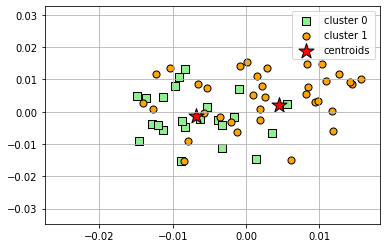

*************************** Start assigning cluster  Bruno Mars  -  Never Say U Can't *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Never Say U Can't *******************************************
["Never Say U Can't, [Intro:]  \nOh [x4]  \n  \n[Verse 1:]  \nWhen I was just a little boy  \nBarely strong enough to stand  \nI could always count on him  \nOh  \n  \nHe thought me everything I know  \nAnd 'till this day it shows  \n  \nHe was more than just a friend (Ah ah ah)  \n  \n[Pre-Chorus:]  \nThere were so many times I would doubt myself  \nBut his words were always there to help  \n  \n[Chorus:]  \nHow would it be?", 'Where I am?', "If my father didn't tell me  \nTo never say I can't  \n  \nHe'd carry me  \nAnd never let me fall  \nOh and the only thing he asked  \nRight before he passed  \nWas to never say you can't  \n  \nOh  \nNever say you can't  \nOh oh oh Oh  \n  \n[Verse 2:]  \nSo when last rain begins to fall  \n

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Test output for words in word2vec
lone
vers
thing
said
rush
door
see
wait
day
want
*************************** Start kmeans cluster  Bruno Mars  -  Only When You're Lonely *******************************************
[[ 2.97171366e-03 -5.30262478e-05  2.33157282e-03  9.66692925e-04
  -2.53715087e-03  4.43545962e-03  6.12081902e-04 -3.15405312e-03
  -2.20796210e-03 -1.28571491e-03  1.32609648e-03  7.90316798e-03
   1.01560050e-04  1.95696787e-03 -1.70288747e-03  2.73587694e-03
   2.79963319e-03  5.32335043e-03  2.03444576e-03  8.37123371e-04
   2.20420584e-03  2.51541147e-03  6.83777733e-04  1.07543485e-03
  -1.53645710e-03 -2.97337072e-03  1.44419598e-03 -7.56879686e-04
  -2.14718026e-03 -3.29122250e-03  2.92837154e-04 -1.64164638e-03]
 [ 1.24326814e-03 -2.40512146e-03  1.24649971e-03 -4.26476123e-03
  -1.32014975e-05 -4.33067139e-03 -5.46061783e-04  1.29810092e-03
  -2.05348502e-03  4.50223946e-04  2.23999657e-03 -5.51907346e-03
   2.42302223e-04 -1.69789454e-03  1.11223781e-03 -4.128

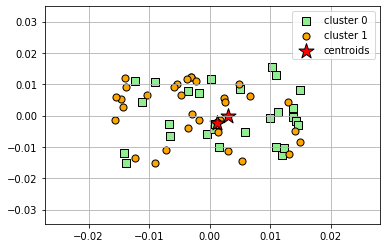

*************************** Start assigning cluster  Bruno Mars  -  Only When You're Lonely *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Only When You're Lonely *******************************************
["Only When You're Lonely, [Verse 1]  \nHere I am again doing things I said that I wouldn't do  \nIt's 3 am and I'm rushing out the door to see you  \nWaiting all day, but now you want to call me  \nWhy do you do this to me all the time?", "[Chorus]  \nAfter all the things you put me through, still I come right back  \nBut now I know the truth, I can finally see  \nYou only want me when you're lonely  \nIf I say I'm going to leave, that's the only time you want me  \nNext time you need me there I won't make it  \nAnother late night call I won't take it  \nCos now I finally see, you only want me when you're lonely  \nOnly when you're lonely, lonely  \nOnly when you're lonely  \nOnly when you're lonely, lonely  \nOnly whe

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[-0.00031027 -0.00363555 -0.00536812  0.0026912   0.00034132 -0.00486081
  -0.00053661 -0.00080422  0.00458966 -0.0006182  -0.00236822  0.00049307
   0.00016634 -0.00171539  0.00027483 -0.00252203 -0.0001999   0.00336403
  -0.00203466 -0.00409268  0.0003426  -0.00163483 -0.00051706 -0.00091005
  -0.00142757 -0.00093057 -0.00134884  0.00233984  0.00256425 -0.00279349
  -0.00051914 -0.00298511]
 [-0.0004472   0.00109183  0.00543271 -0.00206496  0.00058852  0.00195489
   0.00488968  0.00168946 -0.00122007 -0.00314908  0.00612265  0.00390581
  -0.00044613 -0.00227309 -0.00525121 -0.00242827  0.00098963 -0.00263985
   0.00076143  0.00154332 -0.00335588  0.0033083  -0.0008262   0.00304192
  -0.00187063  0.00408025  0.00557967 -0.00079139  0.00222819  0.00185117
  -0.00440261  0.00244558]]


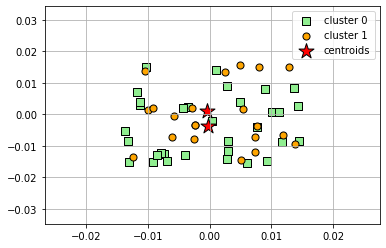

*************************** Start assigning cluster  Bruno Mars  -  Our First Time *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Our First Time *******************************************
["Our First Time, Don't it feel good babe, don't it feel good babe  \n'Cause it's so brand new babe, it's so brand new babe  \n  \nDon't it feel good babe, don't it feel good babe  \n'Cause it's so brand new babe, it's so brand new babe  \n  \nAnd then here we are (here we are), in this big old empty room  \nStaring at each other, who's gonna make the first move?", 'Been doing our thing for a minute, and now both our hearts are in it  \nThe only place to go is all the way  \n  \n[Chorus]  \nOh babe, Is that alright?', 'Is that okay?', "Girl no need to be nervous,  \n'Cause I got you all night, don't you worry about a thing no, no, no,  \nJust go with it, go with it, go with it  \nAnd I will go real slow with it, slow with it  \nIt's our 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[-1.0913407e-03  2.9825747e-03 -1.4705688e-03  5.5347234e-03
  -5.7383478e-03  7.1940040e-03 -2.0510266e-03  4.7487607e-03
  -5.0742546e-04  2.3476377e-03 -4.6893195e-03  5.1053765e-04
  -1.3758009e-03  6.2714266e-03 -8.8911026e-04  2.4010841e-04
   5.0509898e-03  5.0968584e-03  1.9812854e-03 -1.2746528e-03
  -1.2603123e-04 -3.9455988e-03  2.2015616e-04 -2.9321380e-03
   1.7255641e-03 -5.1045092e-04  1.9870228e-03  1.0626077e-03
  -1.4390405e-03 -2.8014928e-03  1.7870021e-03 -1.0209077e-03]
 [ 3.6943723e-03 -9.2839712e-04  2.2906128e-03 -1.2426256e-03
   2.6780013e-03 -3.7277613e-03 -2.1024432e-03 -2.5136354e-03
  -3.5068148e-04 -5.6696115e-03  3.7993013e-03 -5.6106626e-04
  -9.1296813e-04 -3.6226637e-03  9.5981348e-04 -1.7257044e-03
   2.8118445e-04 -5.5206253e-04 -2.1843449e-03 -1.3178678e-03
  -2.7461634e-03  1.7675990e-03  2.4599885e-03  1.5577680e-03
   7.1165152e-05 -2.3476693e-03 -8.6728233e-04  1.4061891e-03
  -1.6401265e-03  2.2028727e-03  3.3925549e-04  2.7539083e-03]]


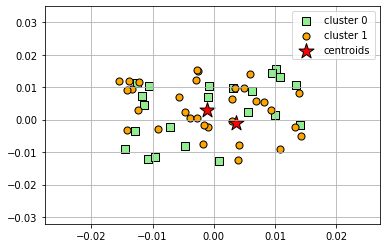

*************************** Start assigning cluster  Bruno Mars  -  Rest *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Rest *******************************************
['Rest, Everyday I wakeup  \nNext to an angel  \nMore beautiful than  \nWords can say.', "They said it wouldn't work  \nBut what do they know?", "Cause years have past  \nAnd we're still here today.", 'Never in my dreams  \nDid I think  \nThat this  \nWould happen to me.', "As I stand here  \nBefore my woman  \nI can't fight back  \nThe tears in my eyes.", 'Oh how could I be so lucky  \nI must have done something right.', 'And I promise to love her  \nFor the rest of my life.', 'It seems like yesterday  \nWhen she first said "Hello"  \nFunny how times fly  \nWhen you\'re in love.', "It took us a lifetime  \nTo find each other  \nIt was worth the wait  \n'Cause I finally found the one.", 'Never in my dreams  \nDid I think  \nThat this  \nWould happen to me.'

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[ 0.00229772  0.00036831  0.00694974 -0.00192295  0.0041421   0.00157108
  -0.00113728 -0.0005282  -0.0020383  -0.00177284 -0.00038101  0.00339169
   0.00026568 -0.00325489 -0.00093739 -0.00158985  0.00090104 -0.00079844
  -0.00076034 -0.00029819  0.00065718  0.00092374  0.00121851 -0.00156796
   0.00069331  0.00075456  0.00358815 -0.00703864  0.00080616  0.00042739
   0.0001609  -0.00028775]
 [-0.00105711  0.00091115 -0.00780181  0.00262124 -0.00506075  0.00054506
   0.00122877  0.00106829  0.00346244 -0.00420861  0.00058594 -0.00127339
   0.00243648 -0.00010249 -0.00195764 -0.00270813  0.00057366  0.00477242
   0.00442076 -0.0009723  -0.00125612 -0.00039632  0.00043432 -0.00027733
  -0.00089147 -0.00064043  0.00237841  0.00493766 -0.00272635 -0.00227667
   0.00064574 -0.00087242]]


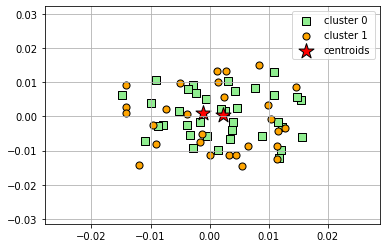

*************************** Start assigning cluster  Bruno Mars  -  Runaway *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Runaway *******************************************
['Runaway, [Verse 1]  \nSo easy to forget our love, the little things we do.', 'Like callin\' for no reason, just to say the words,  \n"Baby, I love you."', "I know lately I've been busy, but a second doesn't go by  \nWithout you crossin' my mind.", "It's been so long since we had time,  \nLet's take a day and make everything 'right.", '[Pre-Chorus]  \nJust take my hand, fall in love with me again.', "[Chorus]  \nLet's runaway to the place where love first found us.", "Let's runaway for the day, don't need anyone around us.", 'When everything in love gets so complicated,  \nIt only takes a day to change it.', "What I have to say can't wait, all I need is a day,  \nSo let's runaway.", "Let's runaway, just for the day,  \nRunaway, runaway.", "[Verse 2] 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[-9.0078922e-04  1.7583342e-03 -4.0601310e-03  3.2537743e-03
   8.8926521e-04 -1.9996685e-03 -4.0837917e-03 -1.2252668e-03
  -9.1182766e-05  1.9451402e-03 -6.5169565e-04  7.4227690e-05
   3.2484448e-03  2.4353014e-03  4.4251913e-03 -3.0226849e-03
   1.6374254e-03 -2.6332220e-04  4.8305551e-03 -6.8048888e-04
  -2.3993177e-03  1.1906219e-03 -5.8172870e-04  1.6655563e-04
  -8.8883360e-04  2.9793463e-04  2.5788595e-03  9.3637948e-04
  -1.7835351e-03 -2.1768529e-03 -1.1298088e-03 -2.3300573e-03]
 [ 1.0642958e-03 -6.9649989e-04  2.9495601e-03 -6.2077278e-03
  -5.3125946e-04  3.2889424e-05  3.6221698e-03  5.1693874e-04
  -4.3470082e-03 -2.1431665e-03  3.6911597e-03  2.7958346e-03
  -8.7548688e-04 -2.7847637e-03 -2.9070463e-03  1.3664868e-03
   5.2833976e-04  6.7351514e-04 -3.2735944e-03 -1.0012853e-03
   1.4689777e-03 -2.5507848e-04 -8.8029169e-04  3.3213347e-03
  -1.2273376e-03 -3.7037996e-03  3.2530522e-03 -6.2594254e-04
   1.7795271e-03  4.6558366e-03  1.4581054e-04  2.7399845e-03]]


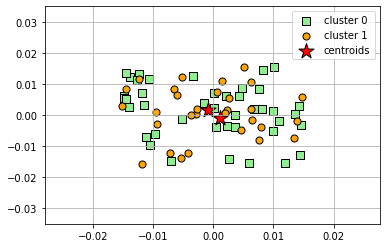

*************************** Start assigning cluster  Bruno Mars  -  Runaway Baby *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Runaway Baby *******************************************
['Runaway Baby, Well looky here looky here ah what do we have?', "Another pretty thing ready for me to grab  \nBut little does she know that I'm a wolf in sheeps clothing  \n'Cause at the end of the night it is her I'll be holding  \n  \nI love you so  \nThat's what you'll say,  \nYou'll tell me baby, baby please don't go away  \nBut when I play, I never stay  \nTo every girl that I meet here, this is what I'll say,  \n  \nRun run runaway, runaway baby  \nBefore I put my spell on you  \nYou better get get getaway, getaway darling  \n'Cause everything you heard is true  \n  \nYou poor little heart will end up alone  \n'Cause lord knows I'm a rolling stone  \nSo you better run run runaway, runaway baby  \nUh, ah yeah  \n  \nWell let me think, 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  She Got Me *******************************************
#Test output for words in word2vec
got
gotta
find
way
bill
babi
sleepin
night
dead
like
*************************** Start kmeans cluster  Bruno Mars  -  She Got Me *******************************************
[[-2.1680654e-04  2.7399650e-03 -1.7363755e-03 -1.5603027e-03
   6.0794671e-04 -1.5657626e-03 -3.7393612e-03  2.6773068e-04
   3.0336701e-03 -5.6207250e-03  1.6143814e-03 -7.0040114e-06
   1.8963336e-03  1.2444786e-03  2.3666664e-04 -1.2049044e-05
   2.6052159e-03  3.3177100e-03 -3.9832783e-03 -2.4912935e-03
  -7.9637271e-04  4.2679440e-03 -5.0200132e-04  9.8399213e-04
  -3.5241263e-03  5.4402353e-04  1.4544432e-03 -1.2850680e-04
   1.0808037e-03  2.1115092e-03  2.0543137e-03  1.5619497e-03]
 [ 1.7821010e-03 -1.6048019e-03  1.5039514e-03  3.1385031e-03
  -1.9220577e-03  5.1476818e-05  7.3093949e-03  4.4362927e-03
  -2.6711170e-03  2.9375006e-03 -2.6139256e-03  3.90

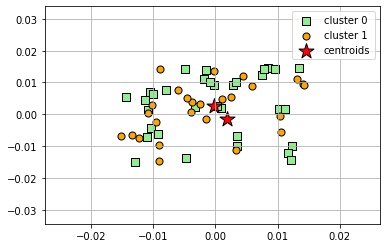

*************************** Start assigning cluster  Bruno Mars  -  She Got Me *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  She Got Me *******************************************
["She Got Me, I gotta find my way out of this bill, you got me into,  \nMy baby's sleepin and the night is dead,  \nIt's like in dreamin that walls are closing in on me,  \nI just wanna know that your okay...", "I wanna find out why, you choose to stay, baby,...  \nYou got me going crazy...  \n  \nOoo... My baby say I'll be oh... No... That she'd let me breathe outside my\nwords, ooo... My baby say I'll be oh... No... That she'd let me breathe it\nlike a creamy note...", "Everyday's the same, your word, life, when all you come and goes in me, I keep\nseeing that, your all brown hair and your white wedding gown, baby I'm missing\nyou...", "I wanna find out why, you choose to stay oh,... Oh ya,... Ooo... My baby say\nI'll be oh... No... That she'd

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Test output for words in word2vec
show
oh
yeah
babi
ooh
see
eye
want
good
time
*************************** Start kmeans cluster  Bruno Mars  -  Show Me *******************************************
[[-0.00046703 -0.00116297 -0.0012097   0.00480782 -0.00371106 -0.00362223
   0.00318055  0.00361823  0.00326864  0.00027532  0.00025471  0.00056819
   0.00017128 -0.00136157 -0.00041515 -0.00570591  0.00080888 -0.00341766
  -0.00108521  0.00236104  0.00053718  0.00241787 -0.00641771 -0.00096633
   0.00348667  0.00113065  0.00373071  0.00475354  0.00378772 -0.00340803
  -0.00656538 -0.0003832 ]
 [ 0.00139924  0.00197987  0.00265204 -0.00173734  0.00312842  0.00265096
  -0.00015393 -0.00129702 -0.00276721 -0.00328782  0.00136893  0.0003783
  -0.001706   -0.00222404  0.00075742 -0.00011473  0.00029831  0.00416407
  -0.00171433 -0.00246033 -0.00136921 -0.0004325   0.00222865  0.00064748
  -0.00024753 -0.00208212  0.00266468 -0.00244988  0.00013391  0.00073966
  -0.00048196 -0.00260286]]


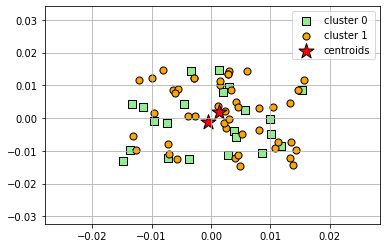

*************************** Start assigning cluster  Bruno Mars  -  Show Me *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Show Me *******************************************
["Show Me, Oh yeah, oh yeah  \nBaby here we are again, ooh  \n  \nI can see it in your eyes, you want a good time  \nYou wanna put your body on mine  \nAlright but don't change your mind, don't you change it, oh no  \n  \nOh yeah you called me today, drove all this way  \nSo don't let this bus go to waste, oh no  \nYour pleasure pleasure island is where we can go  \n  \nNo I won't think you're easy, no I won't think you're fast  \nYour eyes saying please me but your lips care to ask  \nNo need to fight it when you know it feels right  \nYou say you're a woman who knows what she likes  \n  \nThen show me, you got to you got to show me  \nYou tell me all day that you're lonely  \nBut show me show me show me tonight, yeah  \nGirl show me, you got to you 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Somewhere In Brooklyn *******************************************
#Test output for words in word2vec
somewher
brooklyn
cover
leather
gold
twenti
one
year
old
lost
*************************** Start kmeans cluster  Bruno Mars  -  Somewhere In Brooklyn *******************************************
[[-3.0878263e-03  1.4974885e-03 -2.2013707e-03  4.1261096e-03
  -2.5506946e-03  4.7396645e-03  2.8527495e-03 -4.1295402e-03
   2.4331124e-03  2.4629873e-03 -5.8580050e-04  4.0367227e-03
  -4.8019742e-03  6.3125561e-03 -2.4463125e-03 -2.5534439e-03
   3.0035984e-03  2.2393535e-03 -3.0250365e-03 -3.1159674e-03
   4.1084820e-03 -4.1423421e-03  5.5884924e-03 -6.7100010e-04
   1.7129640e-03  2.0529814e-03 -1.8897238e-03  5.1708758e-04
  -2.8660272e-03 -3.5675392e-03  5.7693217e-03 -1.5615164e-03]
 [ 7.6241797e-04  8.2022441e-04  1.0281956e-03 -2.2726858e-03
   1.7289387e-03  8.1901788e-04 -1.6561607e-03  1.4973388e-03
  -3.5315193e-03 -2.2

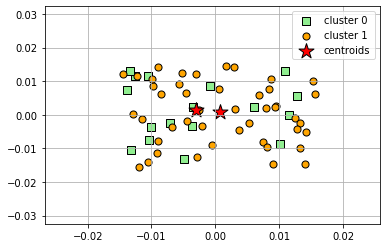

*************************** Start assigning cluster  Bruno Mars  -  Somewhere In Brooklyn *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Somewhere In Brooklyn *******************************************
["Somewhere In Brooklyn, She was covered in leather and gold  \nTwenty one years old  \nI lost her in the cold  \nIt's unfair, she's out there  \n  \nSomewhere, somewhere, somewhere in Brooklyn  \nShe's somewhere, somewhere, somewhere in Brooklyn  \n  \nLittle miss perfect sitting at the train stop  \nRed Nike high tops listening to hip-hop  \nWhile we were waiting started conversating  \nBefore I got her name along came a train  \n  \n(uh) next stop Brooklyn  \n(uh) now I'm lookin'  \n  \nShe was covered in leather and gold  \nTwenty one years old  \nI lost her in the cold  \nIt's unfair, she's out there  \nSomewhere, somewhere, somewhere in Brooklyn  \nShe's somewhere, somewhere, somewhere in Brooklyn  \n  \nOn the street

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Where Did She Go *******************************************
#Test output for words in word2vec
go
look
girl
everytim
came
around
made
bodi
physic
crazi
*************************** Start kmeans cluster  Bruno Mars  -  Where Did She Go *******************************************
[[ 0.00243771  0.00152378 -0.00340492 -0.00083763 -0.00165124  0.00367984
  -0.00204471  0.00160849 -0.00191571 -0.00620215  0.00253996  0.00045386
  -0.0017952   0.0009712  -0.00328679  0.0021213   0.00336144  0.00454318
  -0.00110452 -0.00104015  0.00139189  0.0012238  -0.00045247  0.00143145
   0.00048385 -0.00402764  0.0015709   0.00192304 -0.00342315  0.00136915
  -0.00160429 -0.00013279]
 [-0.00308863 -0.00040374  0.00267013 -0.00040143 -0.00075743 -0.00200443
  -0.00135007  0.00276311  0.00415902  0.00127587  0.00175372  0.00071231
   0.00281496 -0.00202311  0.00411405 -0.00390026 -0.000423   -0.00541657
  -0.00075824 -0.0003951  -0.00272752 

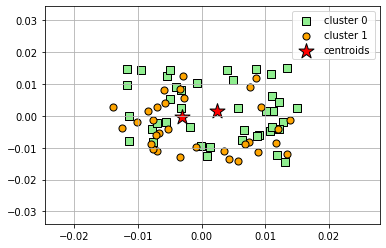

*************************** Start assigning cluster  Bruno Mars  -  Where Did She Go *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Where Did She Go *******************************************
["Where Did She Go, I'm Looking For The Girl  \nI'm Looking For The Girl  \nI'm Looking For The Girl  \nThat Girl That Girl  \n  \nEverytime I Came Around  \nShe Made Her Body Go Down  \nHer Physical Was So Crazy  \nShe Could Make A Blind Man See  \nOoh  \n  \nBefore Then We Got Seperated  \nShe Was Gone Before I Could Say shit  \nAnd I aint Looking For No Replacement  \nNoo-Whoa Whoa Whoa  \nIf I Gotta Almost Search The Whole Club  \nTrying To Get To Her Before she's Sobers Up  \nLet Me See You Throw Your hands Up  \nWhoa Whoa Whoa Whoa Whoa Whoa  \n  \nWhere Did She go  \nWhere Did She go  \nWhere'd She go  \nWhere'd She go  \n  \nI've Been Looking For Her All Night  \nWhere Did She go  \nWhere Did She go  \nWhere'd She go  \nI've 

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*************************** Start vectorization  Bruno Mars  -  Who Is *******************************************
#Test output for words in word2vec
oh
perfect
circu
dare
love
make
stupid
gave
guess
enough
*************************** Start kmeans cluster  Bruno Mars  -  Who Is *******************************************
[[-3.7435151e-03 -1.4328668e-03 -2.6745338e-03 -1.3538486e-03
   6.3400099e-04 -1.2203839e-03 -2.7085403e-03  1.0109711e-03
  -6.4603135e-04 -1.1505258e-03  4.2931864e-04  2.2188525e-03
  -1.3794978e-03 -2.9603669e-03 -3.6291261e-03  1.8590557e-03
  -1.1589859e-03  1.6134591e-03 -1.3562904e-03 -2.4877223e-03
   8.8609033e-04 -2.3053354e-03  1.2215727e-04  2.8843416e-03
   2.3364101e-04 -4.0301471e-03  7.1764539e-04 -5.1558623e-03
   2.9351844e-03 -1.5584831e-03  2.0235544e-03 -4.7718231e-03]
 [ 6.2277624e-03 -6.4525160e-04  3.7383744e-03  2.6976361e-03
   3.1437152e-03 -7.8755734e-04  5.3872271e-03 -3.2575996e-04
  -1.6974362e-03 -3.9335317e-03  1.9396683e-03  1.155486

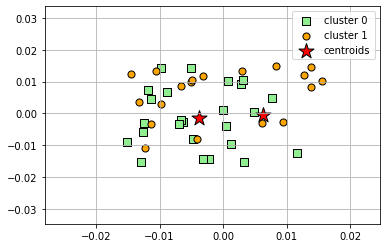

*************************** Start assigning cluster  Bruno Mars  -  Who Is *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Who Is *******************************************
["Who Is, Oh I was perfect  \nFor the circus  \nIf she dared me I'd do it  \nLove makes you stupid  \nI gave it up  \nBut I guess it was not enough  \n'Cause she never seemed satisfied  \n  \nOooh I know I'm not perfect  \nBut at the end of the day  \nWho is?", "Oooh  \nShe wanted someone that's perfect  \nOkay  \nBut can you tell me who is?", "Oooh Ooh Oooh  \nOooh Ooh Oooh  \n  \nShe set the bar  \nJust above the stars  \nA rocket couldn't reach it  \nBut I still kept on reachin'  \nShe watched me try  \nAt least a thousand time  \nIf she loved me she'd stop me but no  \n  \nOooh I know I'm not perfect  \nBut at the end of the day  \nWho is?", "Oooh  \nShe wanted someone that's perfect  \nOkay  \nBut can you tell me who is?", "I saw something worth my

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[-1.1807162e-03 -1.3025893e-03 -4.4417474e-04 -3.6172080e-03
   3.3214621e-03 -1.6323545e-03 -4.3337862e-03 -5.6121955e-03
  -3.5285121e-03 -1.2958325e-03  8.7797042e-04 -1.5244632e-03
   1.4231133e-05 -3.5237710e-03 -2.3812288e-03  1.7991235e-03
   1.2262585e-04  2.4272273e-03 -2.7553416e-03 -1.1607329e-04
  -1.2547007e-03  2.8955550e-03 -1.5037446e-03 -1.0275273e-03
  -1.9564643e-03  1.3104406e-03 -6.3119666e-04 -2.8295475e-03
  -1.9463722e-03  4.8236270e-03 -5.0352118e-04 -1.5489801e-04]
 [ 3.6200006e-03  4.3683901e-04 -4.0353322e-03  1.7005802e-03
  -1.4032510e-03 -5.1459961e-04  3.0268361e-03  1.3592264e-03
   5.2255730e-04  3.9430754e-04  1.3023899e-03  3.5557812e-03
   1.6743699e-03 -1.3032998e-03  5.8596424e-04 -5.8612502e-03
   2.2791503e-03 -2.2268381e-03  2.9723027e-03 -3.6351513e-03
   3.6453162e-03  1.8227275e-04 -3.4671512e-03 -1.5445915e-03
   2.4082039e-03 -2.9009776e-03  4.7570011e-03  9.6874672e-04
   3.4981566e-03 -4.2690048e-03 -7.6574064e-04  1.0410665e-03]]


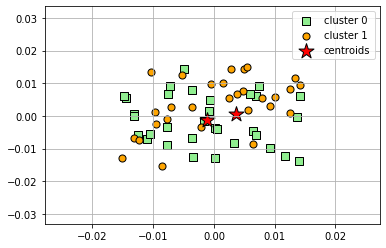

*************************** Start assigning cluster  Bruno Mars  -  Young Girls *******************************************
*************************** Start tf-idf weighting  Bruno Mars  -  Young Girls *******************************************
["Young Girls, I spent all my money on a big old fancy car  \nFor these bright-eyed hunnies  \nOh, yeah, you know who you are  \nKeep me up 'til the sun is high  \n'Til the birds start calling my name  \nI'm addicted and I don't know why  \nGuess I've always been this way  \n  \nAll these roads steer me wrong  \nBut I still drive them all night long, all night long  \n  \nAll you young wild girls  \nYou make a mess of me  \nYeah, you young wild girls  \nYou'll be the death of me, the death of me  \nAll you young wild girls  \nNo matter what you do (No matter what you do)  \nYeah, you young wild girls  \nI'll always come back to you, come back to you  \n  \nI get lost under these lights  \nI get lost in the words I say  \nStart believing my own

/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/jlartey10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
#Import Data

df_songdata = pd.read_csv('songdata1.csv')
# df_songdata = df_songdata[df_songdata.artist == 'Bruno Mars']

#fix song titles to remove ","
song_title_ls = []
for sondx in enumerate(df_songdata["song"]):
    song_title_ls.append(sondx[1].replace(',',''))
    
song_title_ls = np.asarray(song_title_ls) 
df_songdata["song"] = song_title_ls



df_songdata["sentiment"] = ""

for i in range(len(df_songdata)):
    
    #import data
    
    corpus = ''
    artist = df_songdata.iloc[i, 0]
    song = df_songdata.iloc[i, 1]
    text = df_songdata.iloc[i, 3]
    corpus = song + ', ' + text
    
    #Implementation
    

    try:
        
        print("*************************** Start preprocessing ", artist, " - ", song, "*******************************************")
        processed_sent_list = preprocessing(corpus)
        print("*************************** Start vectorization " , artist, " - ", song, "*******************************************")
        word_vectors = vectorize_words(processed_sent_list)
        print("*************************** Start kmeans cluster " , artist, " - ", song, "*******************************************")
        
        
        
        
        
        
        
        model = kmeans_cluster(word_vectors)
        print("*************************** Start assigning cluster " , artist, " - ", song, "*******************************************")
        #df_assign_clusters = pd.DataFrame(word_vectors.vocab.keys()) #Blank dataframe
        df_assign_clusters = assign_clusters(model, word_vectors)
        print("*************************** Start tf-idf weighting " , artist, " - ", song, "*******************************************")
        tf_idf_weights, threshold = tf_idf_weighting(df_assign_clusters)
        print("*************************** Start sentiment prediction ", artist, " - ", song, "*******************************************")
        
        

        
        
        sentiment = sentiment_prediction(tf_idf_weights, threshold)

        #Assign Results

        df_songdata["sentiment"][i] = sentiment
        
        print("$$$$$$$$$$$$$$$$$$$$$$$$$$$ The sentiment prediction of ", artist, " - ", song, " is ", sentiment, "  *******************************************")

        
    except Exception:
        pass
    
        
df_songdata.to_csv("songdata_sentiment_bruno.csv", index=False)



In [9]:
df_songdata

,artist,song,link,text,sentiment
0,Bruno Mars,All About You,/b/bruno+mars/all+about+you_20887728.html,"I know girl, when you look at me \nYou don't ...",Positive
1,Bruno Mars,Circles,/b/bruno+mars/circles_20898395.html,Got me going in circles c-circles \nMy heart ...,Positive
2,Bruno Mars,Click Clack Away,/b/bruno+mars/click+clack+away_20910354.html,You shot me through the heart staring in your ...,Neutral
3,Bruno Mars,Don't Give Up,/b/bruno+mars/dont+give+up_20989970.html,[Bruno Mars] \nWhen you want to do something ...,Neutral
4,Bruno Mars,Dreamtaker,/b/bruno+mars/dreamtaker_20897712.html,Oooohhhh ooohhhh \n \nI used to go out of my...,Positive
...,...,...,...,...,...
65,Bruno Mars,Show Me,/b/bruno+mars/show+me_21048081.html,"Oh yeah, oh yeah \nBaby here we are again, oo...",Positive
66,Bruno Mars,Somewhere In Brooklyn,/b/bruno+mars/somewhere+in+brooklyn_20457310.html,She was covered in leather and gold \nTwenty ...,Neutral
67,Bruno Mars,Where Did She Go,/b/bruno+mars/where+did+she+go_20889303.html,I'm Looking For The Girl \nI'm Looking For Th...,Positive
68,Bruno Mars,Who Is,/b/bruno+mars/who+is_20889300.html,Oh I was perfect \nFor the circus \nIf she d...,Neutral
